# Fundamentos de Aprendizaje Automático y Reconocimiento de Patrones
***
# Práctico 4

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
# %matplotlib notebook

from utils.fuaa_utils import validar_resultado
from utils.fuaa_utils import mostrar_curva_aprendizaje

# Tamaño de las figuras por defecto
plt.rcParams['figure.figsize'] = (7.0, 7.0)

%reload_ext autoreload
%autoreload 2

## Objetivos

Al completar este práctico el estudiante será capaz de:

- Implementar el mecanismo de regularización conocido como **weight decay** en un problema de clasificación
- Implementar e interpretar las **curvas de aprendizaje** como una herramienta útil para entender el grado de ajuste de un modelo a los datos 
- Implementar y aplicar diversos mecanismos de **regularización** en un problema de **regresión polinómica**. Se aplicará: 
    - regularización de **Ridge** mediante su **solución cerrada** y mediante **descenso por gradiente**
    - regularización de **Lasso** 
- Generar un modelo para **predecir** el **valor promedio de las casas** en una determinada región y evaluar su bondad mediante un adecuado uso de conjuntos de **entrenamiento**, **validación** y **test**. 

*** 

## Lista de ejercicios

[Ejercicio 1](#Ejercicio1): regularización con *weight decay*       
[Ejercicio 2](#Ejercicio2): curvas de aprendizaje    
[Ejercicio 3](#Ejercicio3): regularización en el caso de regresión polinómica    
[Ejercicio 4](#Ejercicio4): predecir el valor medio de las casas en una región determinada


# Ejercicio 1: Regularización con Weight Decay  - Clasificación utilizando dos características
<a id="Ejercicio1"></a>

En este ejercicio se verá una de las formas más comunes de regularización: *weight decay*. A continuación se generan los datos y etiquetas para entrenamiento y test.

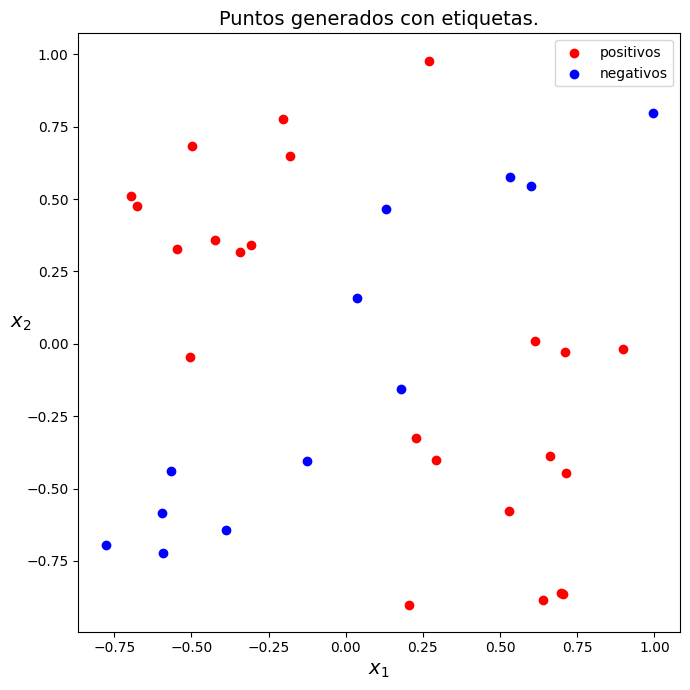

In [2]:
# Funcion para generar los datos
def generar_puntos_ej1 (num_points, seed = 86):
    # Fijo la semilla
    np.random.seed(seed)

    # Genero Datos
    data = np.random.uniform(-1, 1, size=(num_points, 2))
    y = np.ones(num_points)

    # Definir las funciones de las rectas diagonales
    def diagonal_superior(x):
        return x[1] > x[0] - 0.45
    
    def diagonal_inferior(x):
        return x[1] < x[0] + 0.45
    
    # Etiquetar los puntos que están dentro de la franja
    for i in range(num_points):
        if diagonal_superior(data[i]) and diagonal_inferior(data[i]):
            y[i] = -1

    # Convierto a homogeneas
    X = np.ones((data.shape[0], 3))
    X[:, 1:] = data[:, :2]

    return X, y

# Genero los datos
seed = 86
X_train, y_train = generar_puntos_ej1 (num_points = 35, seed = seed)
X_test, y_test = generar_puntos_ej1 (num_points = 350, seed = seed)

# Graficar los puntos
plt.scatter(X_train[y_train == 1, 1],
            X_train[y_train == 1, 2],
            c='r',
            label='positivos')
plt.scatter(X_train[y_train == -1, 1],
            X_train[y_train == -1, 2],
            c='b',
            label='negativos')
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", rotation=0, fontsize=14)
plt.title('Puntos generados con etiquetas.', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

Como las clases no son linealmente separables se aplicará una transformación no lineal a las características. La expectativa es que dicha transformación lleve los datos a un nuevo espacio en que sí puedan separarse utilizando un clasificador lineal.

**Ej1 a)** Implementar el método `transformada_no_lineal()`.

In [3]:
def transformada_no_lineal(X):
    '''
    Entrada: 
        X: matriz de dimensión (N,3) donde cada fila contiene una muestra.
    Salida: 
        Xt: matriz de dimensión (N,8) donde cada fila contiene una muestra en 
            el espacio trasformado. 
        
    Dado un vector de entrada [x1, x2] el vector transformado a devolver es:
    [1, x1, x2, x1^2, x2^2, x1*x2, |x1-x2|,|x1+x2|]
    '''

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    Xt = np.zeros((X.shape[0],8))
    Xt[:,0:3] = X
    Xt[:,3] = X[:,1]**2
    Xt[:,4] = X[:,2]**2
    Xt[:,5] = X[:,1]*X[:,2]
    Xt[:,6] = np.abs(X[:,1]-X[:,2])
    Xt[:,7] = np.abs(X[:,1]+X[:,2])

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    return Xt

In [4]:
# Validar implementación de transformación no lineal.
validar_resultado("transformada_no_lineal", funcion=transformada_no_lineal)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Dimensión de salida: resultado validado.
 Transformación: resultado validado.
+-------------------------------------------------------------------------+


## Regresión lineal sin regularización 

**Ej1 b)** Como clasificador base se utilizará a la regresión lineal para clasificación. Completar el código del método `regresion_lineal()`. En principio no se utilizará ningún tipo de regularización. 

In [5]:
def regresion_lineal(X, y):
    '''
    Entrada:
        X: matriz de dimensión (N,d+1)
        y: arreglo de dimensión (N,)
    Salida:
        w_ls: vector de pesos con dimensión (d+1,) encontrado por la regresión lineal 
    '''
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################
    pseudo = np.linalg.inv(X.T@X)@X.T
    w_ls = pseudo @ y

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    return w_ls

In [6]:
validar_resultado("regresion_lineal", funcion=regresion_lineal)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Implementación de la regresión lineal: resultado validado.
+-------------------------------------------------------------------------+


**Ej1 c)** Clasificar las muestras mediante regresión lineal en el espacio transformado  y calcular el error de entrenamiento.

In [1]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

# Transformar los datos.
Xt_train = transformada_no_lineal(X_train)

# Hallar los coeficientes de la regresión lineal en el espacio transformado.
w_ls = regresion_lineal(Xt_train,y_train)

# Calcular E_in (error de clasificación con el conjunto de entrenamiento).
E_in = np.mean(np.sign(np.dot(Xt_train,w_ls)) != y_train)

print(E_in)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

NameError: name 'transformada_no_lineal' is not defined

**Ej1 d)** ¿Cuál es el error con el conjunto de test?

In [8]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################
Xt_test = transformada_no_lineal(X_test)

E_out = np.mean(np.sign(np.dot(Xt_test,w_ls)) != y_test)

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

print('E_in = %f, E_out = %f' % (E_in, E_out))
print('| E_in - E_out | = %f' %
      (np.abs(E_in - E_out)))  # Esta diferencia debe ser del orden de ~5%

E_in = 0.000000, E_out = 0.042857
| E_in - E_out | = 0.042857


## Regresión lineal con regularización 

A continuación se encontrarán los parámetros del modelo lineal tomando en cuenta, además del ajuste a los datos, un término de regularización. 

$$
E_{aug}(\mathbf{w})=E_{in}(\mathbf{w}) + \lambda \mathbf{w^T}\mathbf{w} 
$$

**Ej1 e)** Implementar el método `regresion_Ridge()`. Para ello utilizar la solución cerrada vista en el curso.   

In [9]:
def regresion_Ridge(X, y, reg, regularizar_bias=False):
    '''
    Implementa la solución cerrada de la regresión de Ridge. En esta variante se
    permite elegir si se desea regularizar el bias (coeficiente w_0) o no.
    
    Entrada:
        X: matriz de dimensión (N,d+1) 
        y: arreglo de dimensión (N,) con los valores objetivo
        reg: coeficiente que multiplica al término de regularización
        regularizar_bias: variable booleana que indica si se regulariza el 
                          término de bias o no.
    Salida:
        w_reg: vector de pesos con dimensión (d+1,) con los parámetros encontrados 
                mediante la regularización de Ridge.
    '''

    # Si no se regulariza el coeficiente w_0 se pone el elemento [0,0]
    # de la matriz identidad a cero
    reg_matrix = np.identity(X.shape[1])
    if not regularizar_bias:
        reg_matrix[0, 0] = 0

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################
    
    
    w_reg = (np.linalg.inv(np.dot(X.T,X)+reg*reg_matrix)@X.T)@y

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    return w_reg

In [10]:
validar_resultado('regresion_Ridge', funcion=regresion_Ridge)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Implementación de la regresión lineal regularizada: resultado validado.
+-------------------------------------------------------------------------+


**Ej1 f)** Evaluar los errores de clasificación $E_{in}$  y $E_{out}$ para factores de regularización de la forma $10^k$ con $k$ entero en el rango $[-6, 6]$.  ¿Cómo valoraría el ajuste del modelo a los datos en $k=-6$?. ¿Y en $k=6$?. De los factores de regularización evaluados, ¿cuál considera que es el óptimo?

<>:32: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\l'
C:\Users\ureca\AppData\Local\Temp\ipykernel_19784\3721558764.py:32: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('log10 $\lambda$')


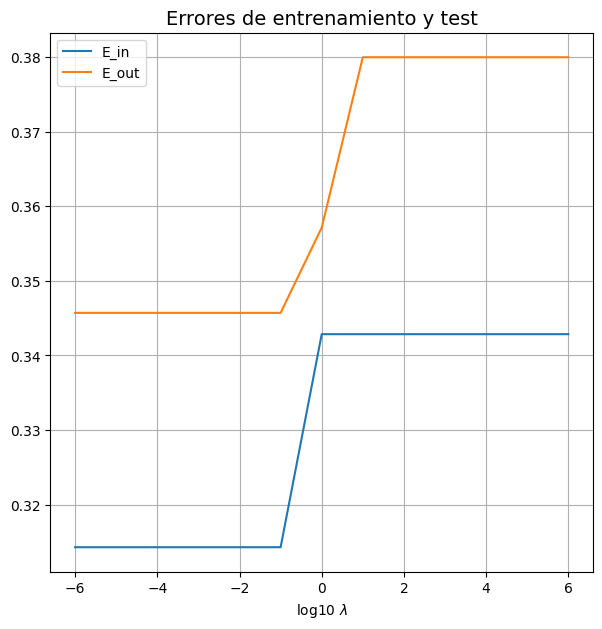

In [11]:
lambdas = 10**np.arange(-6.0, 7.0, 1.0)

# Listas que almacenan los valores de E_in y E_out para los valores de lambda evaluados
E_ins = []
E_outs = []

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

for k in lambdas:
    w_reg = regresion_Ridge(X_train,y_train,k)
    #le hago el Ein
    Ein = np.mean(np.sign(X_train@w_reg)!= y_train)
    E_ins.append(Ein)

    #Le hago el Eout (con los test)
    Eout = np.mean(np.sign(X_test@w_reg)!= y_test)
    E_outs.append(Eout)
    


#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

plt.figure()
plt.plot(np.log10(lambdas), E_ins, label='E_in')
plt.plot(np.log10(lambdas), E_outs, label='E_out')
plt.legend()
plt.title('Errores de entrenamiento y test', fontsize=14)
plt.xlabel('log10 $\lambda$')
plt.grid()

**Respuesta:** ... $\lambda = 0,1$

**Ej1 g)** Si la implementación de las partes anteriores fue correcta seguramente haya podido encontrar un valor del factor de regularización que genere un $E_{out}$ menor que el obtenido sin utilizar regularización. Esta es la utilidad práctica de *weight decay*. Sin embargo, el procedimiento utilizado para encontrar el valor óptimo de $\lambda$ impide considerar a $E_{out}$ como un buen estimador de lo que pasará cuando el algoritmo se ponga en producción. Explique la razón y proponga un mecanismo alternativo para determinar el valor óptimo de $\lambda$ que no invalide a $E_{out}$ como estimador de la capacidad de generalización del modelo.

**Respuesta:**  ... al usar los mismos datos para entrenar el modelo y ajustar un $\lambda$ optimo se corre el ariesgo de sobreajustar los datos

**Ej1 h)** En esta parte se verá por qué a esta forma de regularización se la conoce con el nombre *weight decay*. Mostrar que la regla de actualización de pesos

$$
\mathbf{w}^{new}=\mathbf{w}^{old}(1-\epsilon) - \eta \nabla E_{in}(\mathbf{w})
$$

minimiza la función de costo $E_{aug} = E_{in}(\mathbf{w})+ \lambda \mathbf{w^t}\mathbf{w}$. Exprese $\lambda$ en términos de la constante de caída $\epsilon$ y la velocidad de aprendizaje $\eta$ (*learning rate*).

**Respuesta:**  ... $E_{aug}(w) = E_in(w) + \lambda w^{t}w$ = $\nabla E_{aug}(w) = \nabla E_{in}(w) + \nabla(\lambda w^{t}w) $

como $\nabla(w^tw) = 2w $,

$\nabla E_{aug}(w) = \nabla E_{in}(w) + 2\lambda w $

$w^{new} = w^{old} - \eta *  \nabla E_{aug}(w) $

$w^{new} = w^{old} - \eta\nabla E_{in}(w) - \eta 2\lambda w  $

si $\lambda = \frac{\epsilon}{2\eta}$

$w^{new} = w^{old} - \eta\nabla E_{in}(w) - \epsilon w  $ = $ w^{old}(1-\epsilon) - \eta\nabla E_{in}(w)  $

# Ejercicio 2: Regresión polinómica 
<a id="Ejercicio2"></a>


La transformación polinómica de las características y posterior utilización de un modelo lineal puede utilizarse también en problemas de regresión. Este procedimiento es útil cuando la relación entre las características y la variable dependiente de las mismas es no lineal. 

La siguiente celda genera una variable $y$ que depende no linealmente de las características $X$. En este caso se trabajará con una sola característica para facilitar la visualización de resultados.

In [12]:
# Se genera una relación no lineal ruidosa entre X e y
np.random.seed(42)
Npuntos = 100 
X = 6 * np.random.rand(Npuntos, 1) - 3
a = 0.5
b = 1.
c = 2.
y = a * X**2 + b * X + c + np.random.randn(Npuntos, 1)
y = np.squeeze(y)

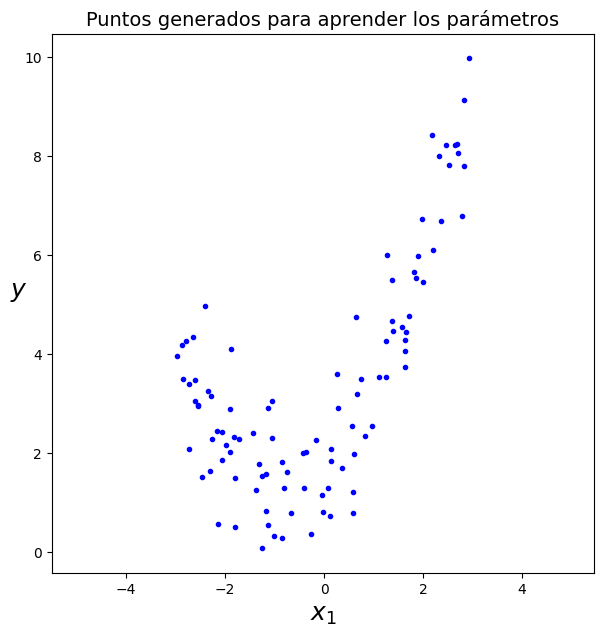

In [13]:
# plt.figure(figsize=(7, 7))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.title('Puntos generados para aprender los parámetros', fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.axis('equal')
plt.show()

De la gráfica resulta evidente que no es posible encontrar una recta que se ajuste bien a los datos. Por lo tanto se propone realizar una transformación polinómica de las características.  

**Ej2 a)** Implementar el método `transformacion_polinomica()` y utilizarlo para realizar una transformación polinómica de grado 2 de la única característica presente originalmente. Encontrar los coeficientes del modelo lineal y verificar que con una cantidad suficiente de datos la estimación es razonable.

In [14]:
def transformacion_polinomica(X, grado=2):
    '''
    Entrada:
        X: matriz de dimensión (N,1) que contiene las características de N muestras
        grado: escalar que indica el grado de la transformación polinómica a realizar
                a las características originales
    Salida:
        Xpoly: matriz de dimensión (N,grado+1) que contiene las características en el 
               espacio transformado (expresado en coordenadas homogéneas) 
    '''

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################
    Xpoly = np.zeros((X.shape[0], grado+1))
    for i in range(0,grado+1):
        Xpoly[:,i] = X[:,0]**i

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################
    return Xpoly

In [15]:
# Validar implementación de transformación polinómica.
validar_resultado("transformacion_polinomica", funcion=transformacion_polinomica)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Dimensión de salida: resultado validado.
 Transformación: resultado validado.
+-------------------------------------------------------------------------+


In [16]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

# Se realiza una transformación polinómica de grado 2
# y se encuentran los coeficientes del modelo lineal

Xpoly2 = transformacion_polinomica(X)

w_ls_2 = np.linalg.inv(Xpoly2.T@Xpoly2)@Xpoly2.T@y

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

# Validar implementación de transformación y regresión.
validar_resultado("Xpoly2", Xpoly2, w_ls_2)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Resultado validado.
 Resultado validado.
+-------------------------------------------------------------------------+


## Visualización del modelo aprendido

**Ej2 b)** Completar la celda y mostrar la curva obtenida. 

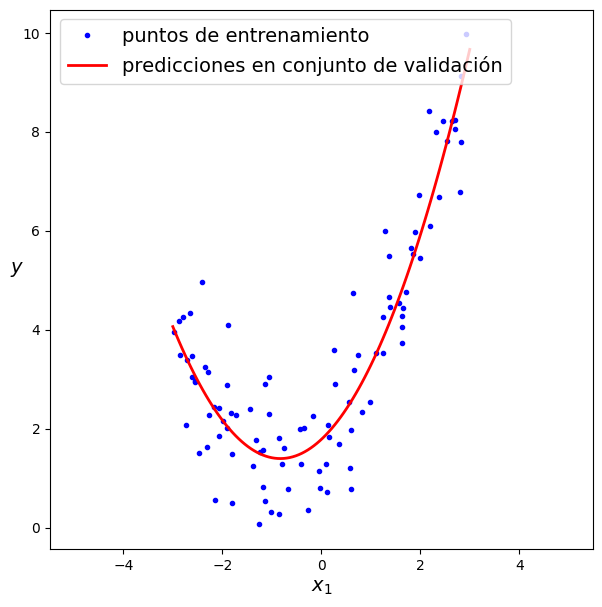

In [17]:
# Se genera un nuevo conjunto de datos en el rango de X para ver como
# se comporta el modelo aprendido en otros puntos del dominio
X_new = np.linspace(-3, 3, 100).reshape(100, 1)

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

# Utilizando el modelo aprendido, se encuentran los valores de $y$ para
# los X_new recientemente generados

y_new = transformacion_polinomica(X_new, 2)@w_ls_2

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

plt.plot(X, y, "b.", label='puntos de entrenamiento')
plt.plot(X_new,
         y_new,
         "r-",
         linewidth=2,
         label="predicciones en conjunto de validación")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.axis('equal')
plt.show()

## Curvas de aprendizaje

Una forma de evaluar la capacidad de generalización de un modelo es mediante la *curva de aprendizaje*. Dicha curva muestra el desempeño en los conjuntos de entrenamiento y validación en función del número de muestras utilizadas para entrenar. 

**Ej2 c)** Completar la implementación del método `generar_curva_aprendizaje()`. Para estimar el desempeño de los modelos aprendidos, dicho método deberá hacer uso del método `mse()` que también será implementado.

In [18]:
def mse(X, y, w):
    '''
    Entrada:
        X: matriz de dimensión (N,d+1) 
        y: arreglo de dimensión (N,) con los valores objetivo
        w: vector de pesos de tamaño (d+1,)
    Salida:
        mse: error cuadrático medio entre la salida del modelo
             lineal y los valores objetivos
    '''

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################
    predic = X@w
    mse = np.mean((y-predic)**2)

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    return mse

In [19]:
def generar_curva_aprendizaje(X, y, valid_size=0.25):
    '''
    Entrada:
        X: matriz de dimensión (N,d+1) que contiene N muestras
        y: arreglo de dimensión (N,) con los valores objetivo
        valid_size: fracción del conjunto de N muestras disponibles que se reservará
                    para test
    Salida:
        train_errors: lista con los errores en el conjunto de entrenamiento
        val_errors: lista con los errores en el conjunto de validación
    '''

    N = X.shape[0]
    d = X.shape[1] - 1
    Ntrain = int((1 - valid_size) * N)

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    # Se divide aleatoriamente el conjunto de datos en entrenamiento y validación
    indices = np.random.permutation(N)
    indices_1 = indices[0:Ntrain]
    indices_2 = indices[Ntrain:N]
    
    X_train = np.zeros((Ntrain,d+1))
        
    X_val = np.zeros((N-Ntrain,d+1))
    y_train = np.zeros(N)
    y_val = np.zeros(N-Ntrain)
    
    X_train = X[indices_1,:]

    X_val = X[indices_2,:]
    
    y_train =  y[indices_1]
  
    y_val = y[indices_2]
    
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    # Variables que se utilizan para almacenar los errores de entrenamiento y
    # validación
    
    train_errors, val_errors = [], []
    Ntrain = X_train.shape[0]
    
  
    
    for n in range(d, Ntrain):

        #####################################################
        ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
        #####################################################

        # se encuentran los parámetros del modelo lineal usando n+1 datos
        X_p = X_train[0:n+1,:]
        y_p = y_train[0:n+1]
        
        w_ls = regresion_lineal(X_p,y_p)
        #np.linalg.inv(X_p.T@X_p)@X_p.T@y_p

        # se calculan los errores en entrenamiento y test
        mse_train = mse(X_train,y_train,w_ls)
        mse_val = mse(X_val,y_val,w_ls)

        #####################################################
        ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
        #####################################################
        
        # se almacena los errores
        train_errors.append(mse_train)
        val_errors.append(mse_val)

    return train_errors, val_errors

### Curva de aprendizaje de un modelo lineal

**Ej2 d)** Asumir un modelo lineal entre entrada y salida (incluyendo además el término de bias) y mostrar la curva de aprendizaje para dicho caso.

(75, 3) (25, 3) (75,) (25,)


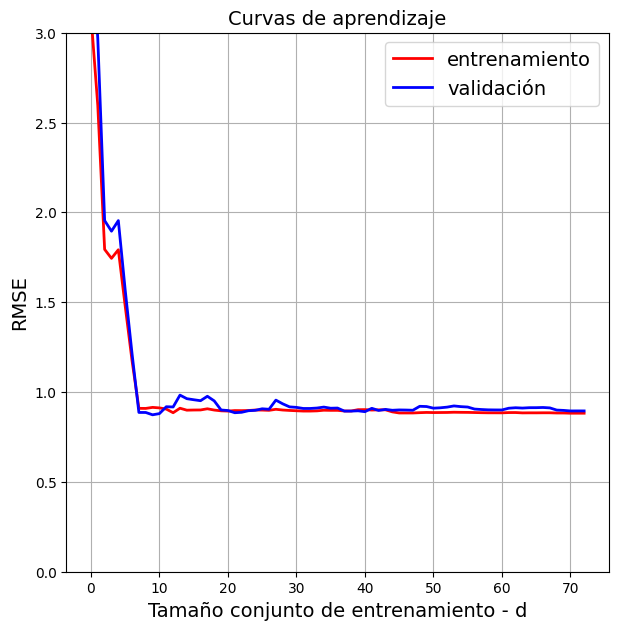

In [20]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

# Se asume un modelo lineal entre la entrada X y la salida y cuando
# en realidad la relación es de segundo grado

Xpoly1 = transformacion_polinomica(X)

train_errors, val_errors = generar_curva_aprendizaje(Xpoly1,y)



#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

mostrar_curva_aprendizaje(train_errors, val_errors)

### Curva de aprendizaje asumiendo como relación un polinomio de orden alto

**Ej2 e)** Aumentar el grado del polinomio (por ejemplo a 10) y comparar las curvas de aprendizaje obtenidas en ambos casos.

**Respuesta:** ...

(75, 11) (25, 11) (75,) (25,)


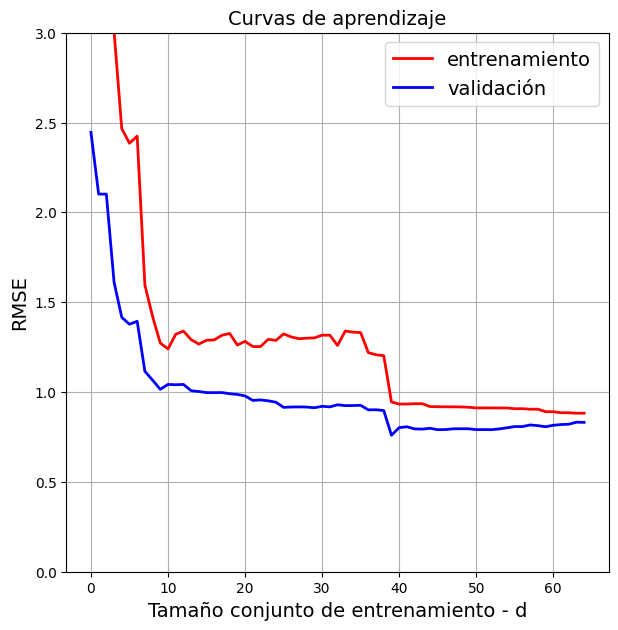

In [21]:
nuevoGrado = 10

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

# Se asume una relación polinómica de alto grado entre la entrada X y la salida y
# cuando en realidad la relación es de segundo grado

Xpoly10 = transformacion_polinomica(X,grado = nuevoGrado)

# se genera la curva de aprendizaje
train_errors_10, val_errors_10 = generar_curva_aprendizaje(Xpoly10,y)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

mostrar_curva_aprendizaje(train_errors_10, val_errors_10)

# Ejercicio 3: Regresión polinómica regularizada
<a id="Ejercicio3"></a>


Se verá el efecto que tiene la regularización en la regresión polinómica. Para ello se generarán puntos pertenecientes a una recta, a los cuales se le agrega ruido gaussiano. Se trabajará con pocos puntos de entrenamiento y muchos de test para que el efecto sea más evidente.

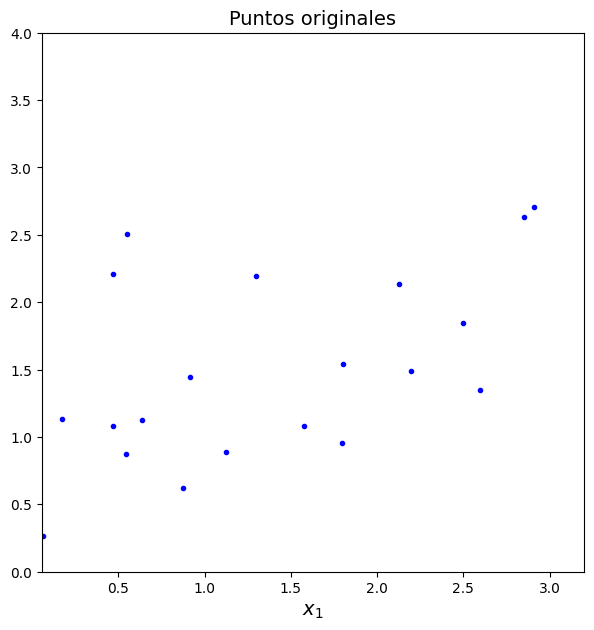

In [22]:
# Setear la semilla para que el experimento sea repetible
np.random.seed(42)  
Ntrain = 20  
Ntest = 100  

# Generar puntos aleatorios en el rango [0,3]
X = 3 * np.random.rand(Ntrain, 1)

# Generar una relación lineal ruidosa entre X e y
y = 1 + 0.5 * X + np.random.randn(Ntrain, 1) / 1.5

# Generar puntos de test en el mismo rango que X
X_test = np.linspace(0, 3, Ntest).reshape(Ntest, 1)

# plt.figure(figsize=(5, 5))
plt.plot(X, y, "b.", linewidth=3)
plt.xlabel("$x_1$", fontsize=14)
plt.axis([X.min()*.9, X.max()*1.1, 0, 4])
# plt.axis([0, 3, 0, 4])
plt.title('Puntos originales', fontsize=14);

**Ej3 a)** El método  `comparar_regularizaciones()` muestra cómo cambian los modelos aprendidos al variar el factor de regularización cuando se utiliza la regularización de Ridge.  Completar la implementación del método `comparar_regularizaciones()`.

In [23]:
def comparar_regularizaciones(X,
                              y,
                              X_val,
                              grado=1,
                              lambdas=1,
                              regularizar_bias=False):
    '''
    Para un modelo polinómico del grado pasado como parámetro se muestra el efecto 
    que tiene la regularización de Ridge. El método genera internamente los modelos 
    para los factores de regularización pasados como argumento.
    Entrada:
        X: matriz de dimensión (N,1) que contiene N muestras.
        y: arreglo de dimensión (N,)  que contiene los valores asociados a cada muestra.
        X_val: matriz de dimensión (M,1) que contiene M muestras no utlizadas 
                para ajustar el modelo.
        grado: grado de la transformación polinómica
        lambdas: lista que contiene los factores de regularización a comparar. 
    '''

    ########################################################
    ######### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO ########
    ########################################################

    # Se encuentran las características en el espacio transformado utilizando el
    # grado de polinomio pasado como parámetro

    Xt_train = transformacion_polinomica(X, grado = grado)
   
    Xt_val = transformacion_polinomica(X_val, grado = grado)

    ########################################################
    ######### TERMINA ESPACIO PARA COMPLETAR CÓDIGO ########
    ########################################################

    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    ax.plot(X, y, 'b.', label='puntos originales')

    # para los factores de regularización pasados como argumento se encuentran los
    # parámetros del modelo utilizando la regularización de Ridge
    for l in lambdas:

        ##########################################################
        ######### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO ##########
        ##########################################################
        # Se encuentra el w_reg mediante el criterio de mínimos cuadrados con
        # regularización de Ridge (solución cerrada). No regularizar el bias.
        # Utilizar el método ya implementado en el Ejercicio 1

        w_reg = regresion_Ridge(Xt_train,y,l)

        y_pred = Xt_val@w_reg

        ##########################################################
        ######### TERMINA ESPACIO PARA COMPLETAR CÓDIGO ##########
        ##########################################################

        ax.plot(X_val, y_pred, linestyle='--', label='lambda = %.02f' % (l))

    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("$y$", rotation=0, fontsize=14)
    ax.set_title("Modelo es un polinomio de grado %d \n (solución cerrada)" %
                 grado,
                 fontsize=14)
    ax.axis([X_val.min() - X_val.max() * 0.01, X_val.max() * 1.01, 0, 4])
    ax.legend(loc='upper left', bbox_to_anchor=(1., 1., 0, 0), fontsize=14)
    plt.tight_layout()

Ejecutar la siguiente celda para observar el efecto de la regularización cuando la relación es polinómica de grado 1 y cuando es de grado 10.

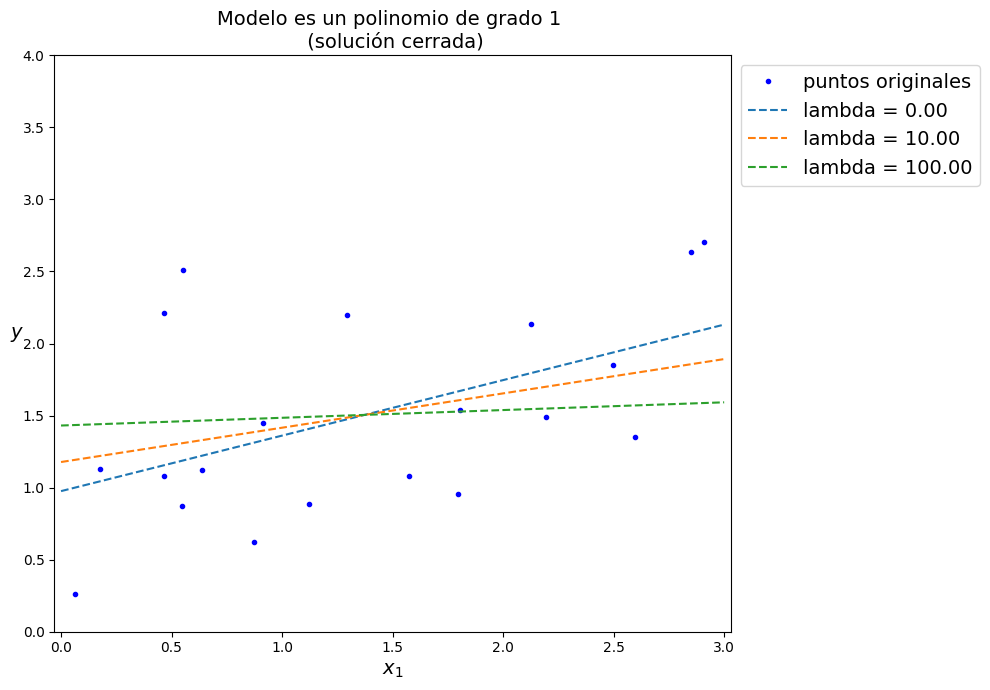

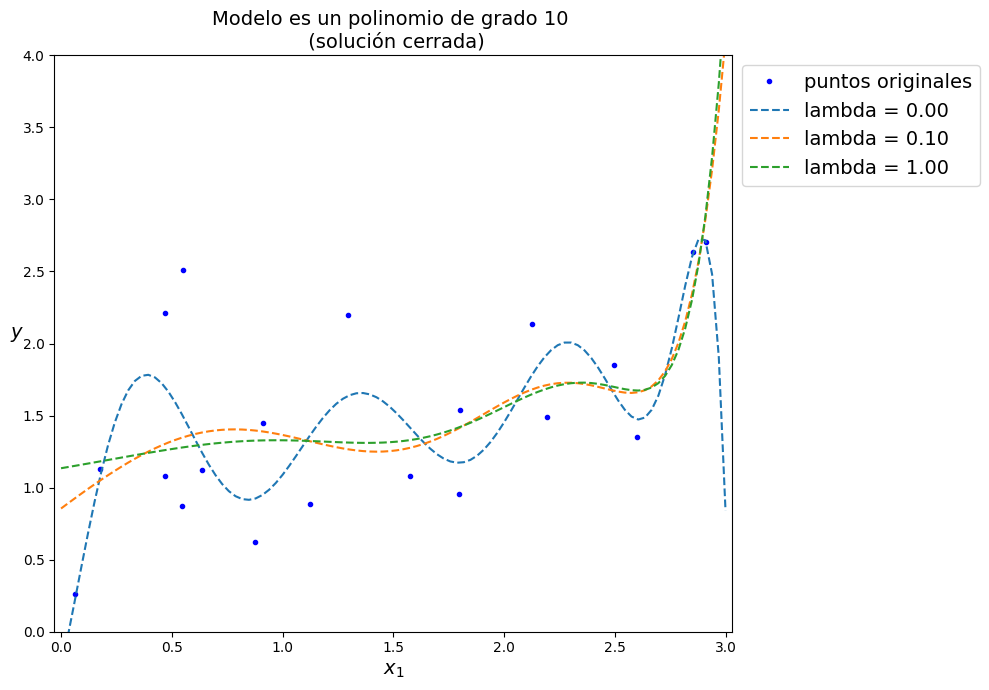

In [24]:
# Comparar el efecto de la regularización cuando se utiliza un modelo lineal
comparar_regularizaciones(X, y, X_test, lambdas=[0, 10, 100])

# Comparar el efecto de la regularización cuando el conjunto de hipótesis son
# los polinomios de orden alto.
comparar_regularizaciones(X, y, X_test, grado=10, lambdas=[0, 0.1, 1])

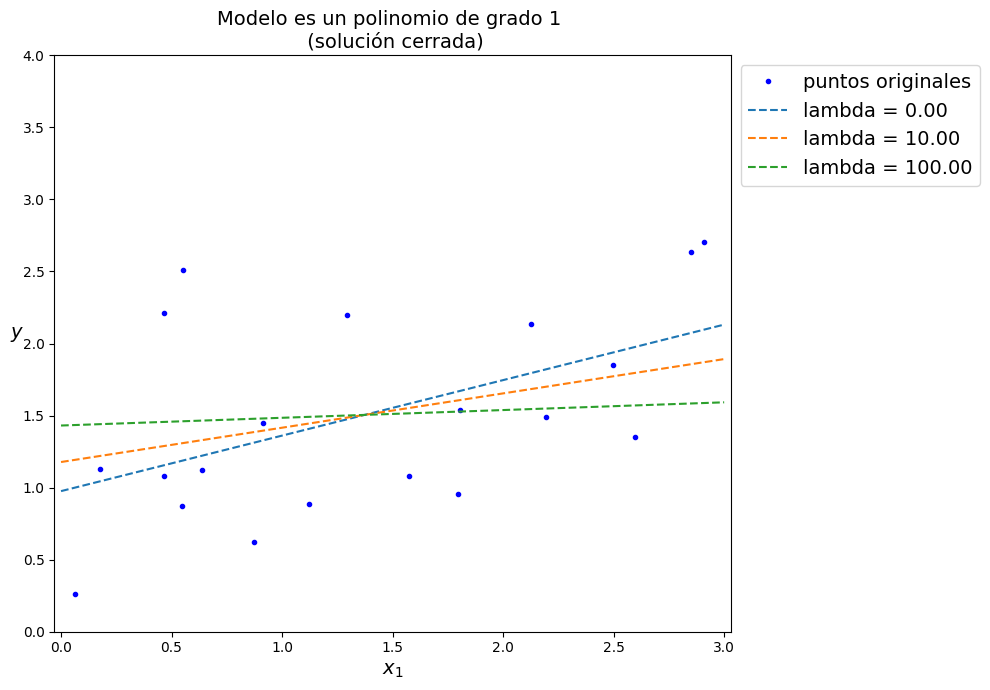

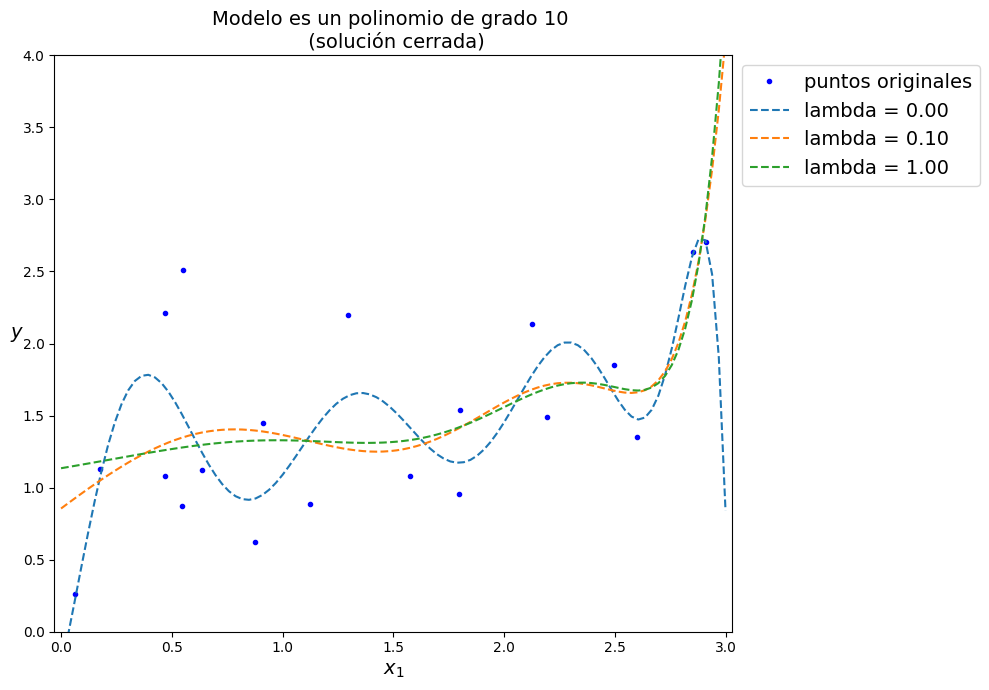

In [25]:
# Comparar el efecto de la regularización cuando se utiliza un modelo lineal.
comparar_regularizaciones(X,
                          y,
                          X_test,
                          lambdas=[0, 10, 100],
                          regularizar_bias=True)

# Comparar el efecto de la regularización cuando el conjunto de hipótesis son
# los polinomios de orden alto.
comparar_regularizaciones(X,
                          y,
                          X_test,
                          grado=10,
                          lambdas=[0, 0.1, 1],
                          regularizar_bias=True)

**Pregunta:**  ¿Cómo afecta el factor de regularización en la solución obtenida? Ejemplificar utilizando un modelo lineal (polinomio de grado 1) y un modelo polinómico de orden alto, por ejemplo 10.  

**Respuesta:**  ... En el polinomio de grado 1, sin importar mucho la regularizacion, te da soluciones muy parecidas, aun asi con regularizacion se aproxima mejor, pero en el polinomio de grado 10, hay una minima regularizacion, afecta mucho al comportamiento de la funcion

## Regularización mediante descenso por gradiente

La regularización de Ridge admite una solución cerrada, sin embargo otras formas de regularización no tienen una solución analítica cerrada. En dichos casos la solución se encuentra utilizando alguno de los métodos de optimización disponibles. A pesar de ser una de las técnicas más sencillas, la de *descenso por gradiente* es por lejos la más utilizada en aprendizaje automático. 

**Ej3 b)** Implementar la regularización de *Ridge* y de *Lasso* mediante la técnica de *descenso por gradiente estocástico*. Para ello completar la implementación de `regresion_lineal_SGD()`.  

**Regularización de Ridge:**

\begin{align}
E_{aug} & = E_{in} + E_{Ridge}  \\
        & = \frac{1}{2N} \sum_{n=1}^N \left( y_n - \mathbf{w}^T\mathbf{x_n} \right)^2  + \frac{\lambda}{2} \sum_{i=1}^d w_i^2
\end{align}

**Regularización de Lasso:**

\begin{align}
E_{aug} & = E_{in} + E_{Lasso}  \\
        & = \frac{1}{2N} \sum_{n=1}^N \left( y_n - \mathbf{w}^T\mathbf{x_n} \right)^2  + \lambda \sum_{i=1}^d \vert w_i \vert
\end{align}

Observar que en ambos casos no se regulariza el término $w_0$.

In [26]:
def regresion_lineal_SGD(X,
                         y,
                         lr=1e-3,
                         reg_type='None',
                         reg_factor=1.0,
                         max_epocas=100,
                         delta_w_minimo=1e-12):
    '''
    Método que implementa regresión lineal mediante el método de descenso por gradiente. Se admiten
    dos tipos de regularización: Ridge y Lasso. El valor por defecto reg_type='None' no aplica 
    regularización. 
    
    Entrada:
                 X: matriz de dimensión (N,d+1) donde cada fila representa una muestra
                 y: arreglo de dimensión (N,) que contiene las etiquetas
                lr: learning rate
          reg_type: [None, Ridge, Lasso]
        reg_factor: factor de regularización. Se utiliza cuando reg_type es Ridge o Lasso.
        max_epocas: número máximo de épocas que dura la optimización. Una época es un pasaje 
                    completo por todas las muestras de X. 
    delta_w_minimo: si la norma L2 del vector diferencia entre vectores de pesos de dos 
                    épocas consecutivos es menor que delta_w_minimo se detiene la optimización
    Salida:
                 w: vector de pesos encontrado
             ws_L2: lista que contiene las normas L2 de todos los vectores de pesos encontrados 
                    durante el entrenamiento
    '''
    N = X.shape[0]
    d = X.shape[1] - 1

    # inicialización del vector de pesos
    w = 1e-6 * np.random.randn(X.shape[1])

    # inicialización de la lista con las normas L2 de los w
    ws_L2 = [np.linalg.norm(w, ord=2)]

    delta_w = delta_w_minimo + 1  # de esta forma entra seguro al menos una vez
    epoca_actual = 0  # contador de épocas

    while (epoca_actual < max_epocas and delta_w > delta_w_minimo):

        # guardo el w de la época anterior
        w_ = w.copy()

        indices = np.random.permutation(N)

        for i in indices:

            ##########################################################
            ######### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO ########
            ##########################################################

            # se calcula el gradiente utilizando una sola muestra
            grad = - (y[i] - (w@X[i]))*X[i]

            # en caso de aplicar regularización, se calcula el gradiente del término
            # de regularización. No se regulariza el bias.
            if reg_type != "None":
                if reg_type == "Ridge":
                    grad = grad + reg_factor*np.sum(w)
                else:
                    grad = grad + reg_factor*np.sum(np.sign(w))

            # se actualiza el vector de pesos
            w = w - lr*grad

            # se almacena la norma L2 del vector de pesos
            norma = np.sqrt(np.sum(w**2))
            ws_L2.append(norma)

            ##########################################################
            ######### TERMINA ESPACIO PARA COMPLETAR CÓDIGO ########
            ##########################################################

        delta_w = np.linalg.norm(w_ - w, ord=2)
        epoca_actual = epoca_actual + 1

    return w, ws_L2

El método  `comparar_regularizaciones_SGD()` muestra cómo cambian los modelos aprendidos al variar el factor de regularización cuando se implementa la regularización utilizando *descenso por gradiente estocástico*.  

In [27]:
def comparar_regularizaciones_SGD(X,
                                  y,
                                  X_val,
                                  lr=0.1,
                                  grado=1,
                                  reg_type=None,
                                  lambdas=[0],
                                  estandarizar=False,
                                  max_epocas=1000):
    '''
    Entrada:
                   X: matriz de dimensión (N,1) que contiene N muestras.
                   y: arreglo de dimensión (N,) que contiene los valores asociados a cada muestra.
               X_val: matriz de dimensión (M,1) que contiene M muestras no utlizadas para 
                      ajustar el modelo.
                  lr: tasa de aprendizaje (learning rate)
               grado: grado de la transformación polinómica
             lambdas: factores de regularización a utilizar en la comparación
        estandarizar: valor booleano que indica si se realiza estandarización de los datos
          max_epocas: número máximo de épocas que puede durar la oprimización
    '''

    # Se encuentran los coeficientes del polinomio en el espacio transformado
    X_poly = transformacion_polinomica(X, grado)
    X_poly_val = transformacion_polinomica(X_val, grado)
    print('Se transformó la entrada a un polinomio grado %d, regularización ' %
          grado + reg_type)

    if estandarizar:
        X_poly, _ = estandarizar_caracteristicas(X_poly)
        X_poly_val, _ = estandarizar_caracteristicas(X_poly_val)

    fig = plt.figure(figsize=(15, 7))
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(X, y, 'b.', label='puntos originales')
    #plt.legend(loc="upper left", fontsize=15)
    ax1.set_xlabel("$x_1$", fontsize=14)
    ax1.set_ylabel("$y$", rotation=90, fontsize=14)
    ax1.set_title(
        "Modelo es un polinomio de grado %d \n (solución iterativa)" % grado,
        fontsize=14)
    ax1.axis([X_val.min()-X_val.max()*.01, X_val.max()*1.01, 0, 4])
    ax2 = plt.subplot(1, 2, 2)
    ax2.set_xlabel('actualización', fontsize=14)
    ax2.set_ylabel('norma L2 de los pesos', fontsize=14)
    ax2.set_title('Evolución de la norma de los pesos', fontsize=14)

    for l in lambdas:
        print("Entrenando clasificador con lambda = %f" % l)
        w_reg, normasL2_w = regresion_lineal_SGD(X_poly,
                                                 y,
                                                 lr=lr,
                                                 reg_type=reg_type,
                                                 reg_factor=l,
                                                 max_epocas=max_epocas)

        y_pred = X_poly_val @ w_reg
        ax1.plot(X_val, y_pred, linestyle='--', label='lambda=%.04f' % l)
        ax2.plot(normasL2_w,
                 label='$\mathbf{w}^*$=%s' %
                 (np.array2string(w_reg, precision=3)))

    ax1.legend()
    ax2.legend(loc='upper left', bbox_to_anchor=(1., 1., 0, 0), fontsize=10)
    plt.tight_layout()

<>:60: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ureca\AppData\Local\Temp\ipykernel_19784\2164161419.py:60: SyntaxWarning: invalid escape sequence '\m'
  label='$\mathbf{w}^*$=%s' %


Ejecutar las siguientes celdas y verificar que con valores de *learning rate* y *factor de regularización* adecuados es posible obtener resultados similares a los obtenidos con la solución cerrada. 

Se transformó la entrada a un polinomio grado 1, regularización Ridge
Entrenando clasificador con lambda = 0.000000
Entrenando clasificador con lambda = 1.000000
Entrenando clasificador con lambda = 10.000000


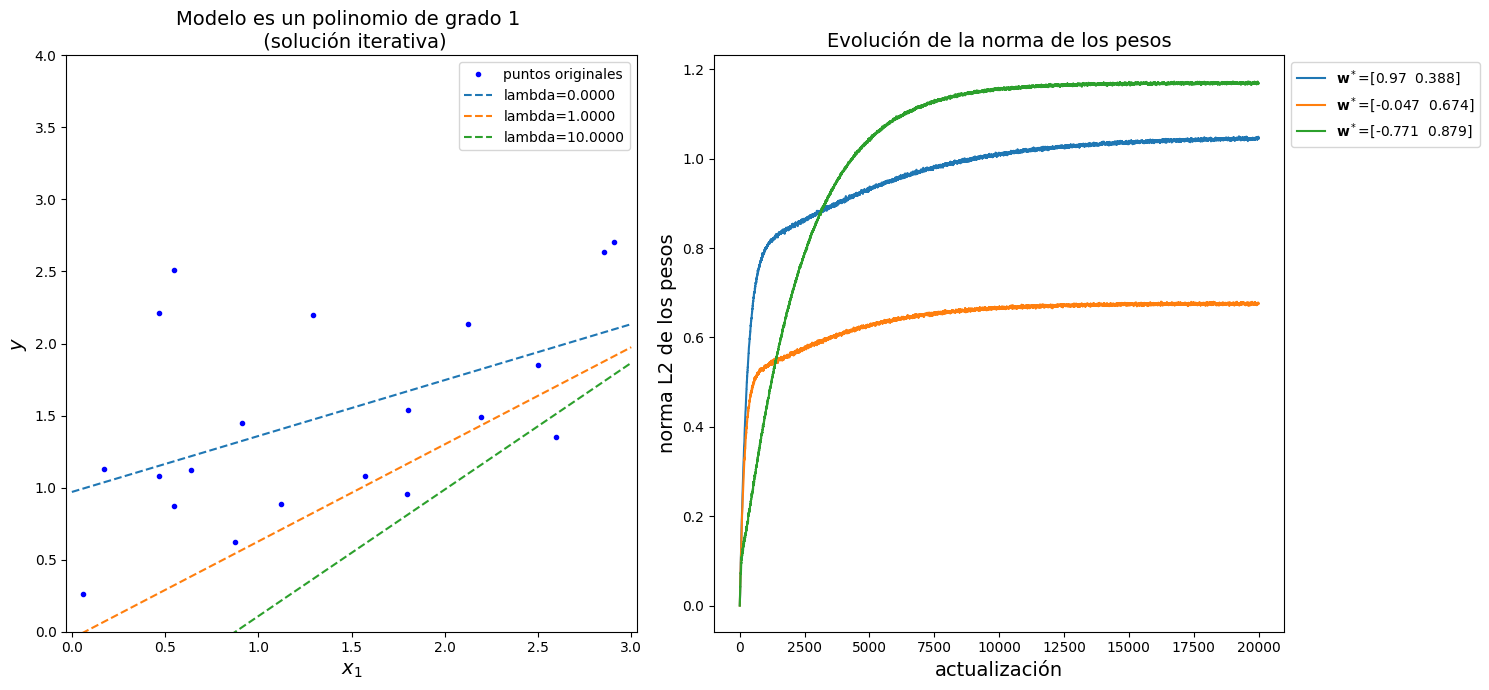

In [28]:
comparar_regularizaciones_SGD(X,
                              y,
                              X_test,
                              lr=1e-3,
                              grado=1,
                              reg_type='Ridge',
                              lambdas=[0, 1, 10])

**SUGERENCIA:** Verifique que los resultados obtenidos con polinomios de grado 1 son razonables. La comparación de regularizaciones con polinomios de orden 3  puede demorar unos minutos, tenga paciencia.

**Atención: Puede demorar.**

Se transformó la entrada a un polinomio grado 3, regularización Ridge
Entrenando clasificador con lambda = 0.000000


C:\Users\ureca\AppData\Local\Temp\ipykernel_19784\2164161419.py:60: SyntaxWarning: invalid escape sequence '\m'
  label='$\mathbf{w}^*$=%s' %


KeyboardInterrupt: 

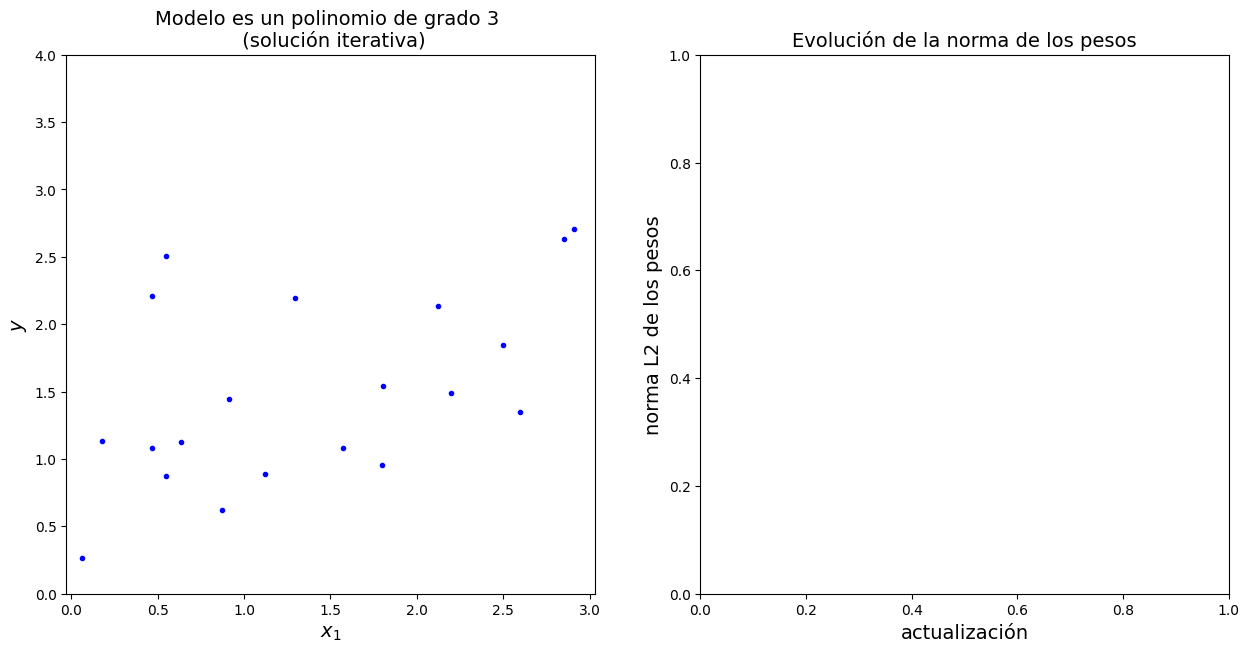

In [29]:
comparar_regularizaciones_SGD(X,
                              y,
                              X_test,
                              lr=1e-3,
                              grado=3,
                              reg_type='Ridge',
                              lambdas=[0, 0.01, 0.1],
                              max_epocas=100000)

## Estandarización

**Nota:** [why-is-gradient-descent-so-bad-at-optimizing-polynomial-regression](https://stats.stackexchange.com/questions/350130/why-is-gradient-descent-so-bad-at-optimizing-polynomial-regression)

La optimización mediante *descenso por gradiente* en el caso de la regresión polinómica puede ser dificultosa debido a que coexisten términos muy grandes junto con otros muy pequeños. Para mitigar este mal condicionamiento, es conveniente aplicar un preprocesamiento de los datos de forma tal que todas las características tomen rangos de valores similares. Las dos técnicas de preprocesamiento más utilizadas en este sentido son: *normalización* y *estandarización*. Mediante la *normalización* se fuerza a que los datos estén en el rango $[0,1]$. Con la *estandarización*, en cambio, se hace que los datos tengan media $0$ y desviación estandar 1.

**Ej3 c)** Implementar el método `estandarizar_caracteristicas()` y verificar su correcto funcionamiento ejecutando la celda contigua al mismo. Observar que dicho método es utilizado por `comparar_regularizaciones_SGD()`.

In [30]:
def estandarizar_caracteristicas(X, mu_sigma=None):
    '''
    Entrada:
            X: matriz de dimensión (N,d+1) que en cada fila contiene un vector de características 
               expresado en coordenadas homogéneas
     mu_sigma: matriz de dimensión (2,d) que contiene los valores mu y sigma que se utilizan para 
               hacer la transformación de las características. Cuando es igual a None, 
               los valores de mu_sigma se calculan utilizando los datos de entrada X. La primera
               fila de la matriz contiene el valor medio de cada una de las características y la
               segunda la desviación estándar.
    Salida:
         Xstd: matriz de dimensión (N,d+1) que en cada fila contiene un vector de 
               características con sus características estandarizadas
     mu_sigma: matriz de dimensión (2,d) que contiene los valores mu y sigma que se utilizaron para 
               hacer la transformación de las características.
    '''

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################
    d = X.shape[1] - 1 
    N = X.shape[0]
    
    if mu_sigma is None:
        
        mu_sigma = np.zeros((2, d))
        for j in range(0,d):
            mu_sigma[0,j] = np.mean(X[:,j+1])
        
        for i in range(0,d):
            mu_sigma[1,i] = np.sqrt(np.mean( (X[:,i+1] - mu_sigma[0,i] )**2 ))
            #mu_sigma[1,i] = np.std(X[:,i+1])
            #mu_sigma[1,i] = np.mean( X[:,i+1])**2 - np.mean(X[:,i+1]**2)
            #mu_sigma[1,i] = np.mean( (X[:,i+1] - np.mean(X[:,i+1]))**2 )
       
    
    Xstd = np.ones((N,d+1))
    
    for i in range(0,N):
        Xstd[i,1:] = (X[i,1:] - mu_sigma[0,:]) / mu_sigma[1,:] 

    #print(Xstd[0,1])
    #print((X[0,1] - mu_sigma[0,0])/mu_sigma[1,0])
   
    
    
    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    return Xstd, mu_sigma

La siguiente celda hace algunos controles para detectar posibles errores en la implementación del método `estandarizar_caracteristicas()`. Asegúrese que puede ejecutarla sin generar mensajes de error.

In [31]:
# Validación de la estandarización de características. Se utilizan datos
# generados durante la validación. Se verifica salida con media nula,
# desviación estándar 1, coordenadas homogeneas, retorno de pasaje de mu_sigma
# y estandarización calculada.
caract_uniformes = np.random.rand(100, 5)
caract_uniformes[:, 0] = 1
caract_estandarizadas, mu_sigma = estandarizar_caracteristicas(
    caract_uniformes)
validar_resultado("estandarizar_caracteristicas",
                  caract_estandarizadas,
                  mu_sigma,
                  funcion=estandarizar_caracteristicas)

+-------------------------------------------------------------------------+
|                         FuAA: validar resultado                         |
+-------------------------------------------------------------------------+
 Las características tienen media cero.
 Las características tienen desviación estandar 1.
 Las características expresadas en coordenadas homogéneas.
 Retorno de mu_sigma correcto.
 Estandarización validada con pasaje de mu_sigma.
+-------------------------------------------------------------------------+


Observar que debido a la *estandarización* de características el rango de valores de *learning rate* y *grado* de polinomio en que el descenso por gradiente puede ejecutarse sin generar problemas numéricos es mayor.

Se transformó la entrada a un polinomio grado 4, regularización Ridge
Entrenando clasificador con lambda = 0.000000


C:\Users\ureca\AppData\Local\Temp\ipykernel_19784\964476962.py:68: RuntimeWarning: overflow encountered in square
  norma = np.sqrt(np.sum(w**2))
C:\Users\ureca\miniconda3\envs\fuaa\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\ureca\AppData\Local\Temp\ipykernel_19784\964476962.py:54: RuntimeWarning: overflow encountered in multiply
  grad = - (y[i] - (w@X[i]))*X[i]
C:\Users\ureca\AppData\Local\Temp\ipykernel_19784\964476962.py:60: RuntimeWarning: invalid value encountered in scalar multiply
  grad = grad + reg_factor*np.sum(w)


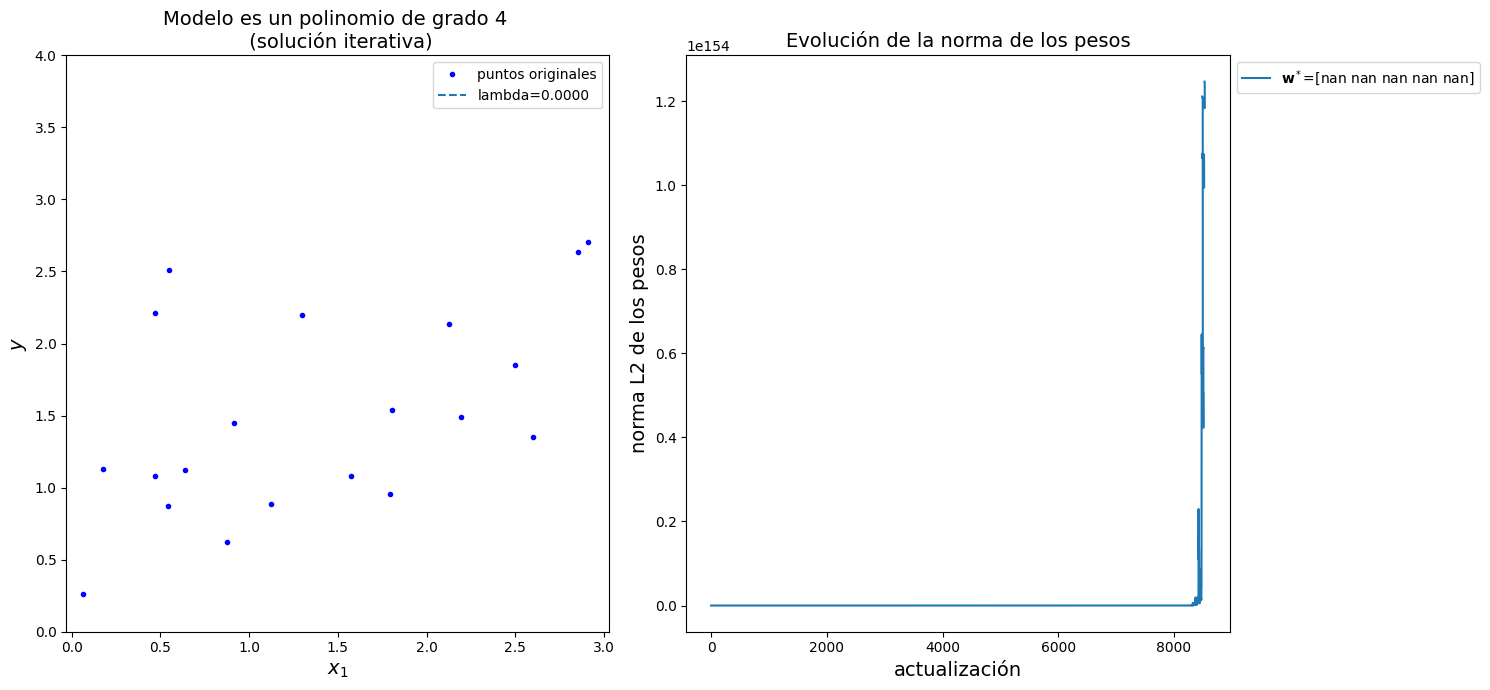

In [32]:
# Ver que para polinomios de orden alto se produce overflow
comparar_regularizaciones_SGD(X,
                              y,
                              X_test,
                              lr=1e-3,
                              grado=4,
                              reg_type='Ridge',
                              lambdas=[0],
                              max_epocas=1000,
                              estandarizar=False)

Se transformó la entrada a un polinomio grado 12, regularización Ridge
Entrenando clasificador con lambda = 0.000000


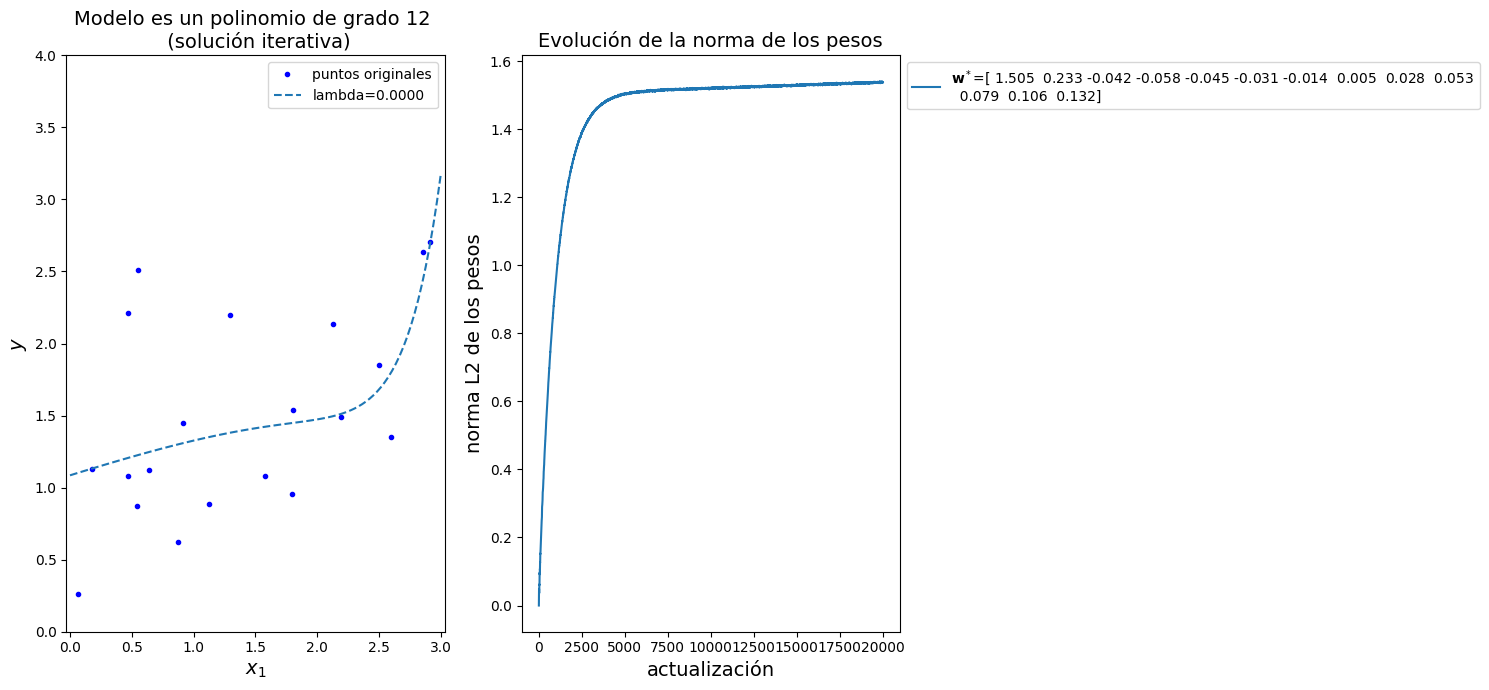

In [33]:
# Con estandarización de los datos se puede trabajar con polinomios de mayor orden
comparar_regularizaciones_SGD(X,
                              y,
                              X_test,
                              lr=1e-3,
                              grado=12,
                              reg_type='Ridge',
                              lambdas=[0],
                              max_epocas=1000,
                              estandarizar=True)

**Ej3 d)** Comparar los resultados obtenidos mediante la solución cerrada con los obtenidos mediante descenso por gradiente para distintos grados de polinomio. ¿Qué puede decir respecto a la solución obtenida mediante descenso por gradiente estocástico?

**Respuesta:**  ...

Se transformó la entrada a un polinomio grado 3, regularización Ridge
Entrenando clasificador con lambda = 0.000000
Entrenando clasificador con lambda = 0.010000


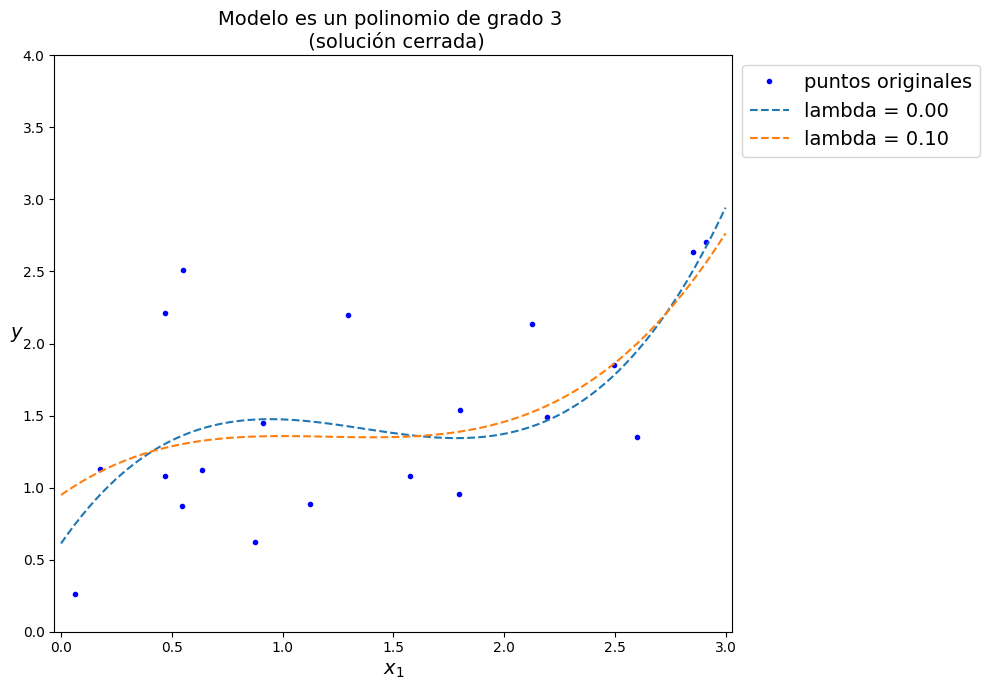

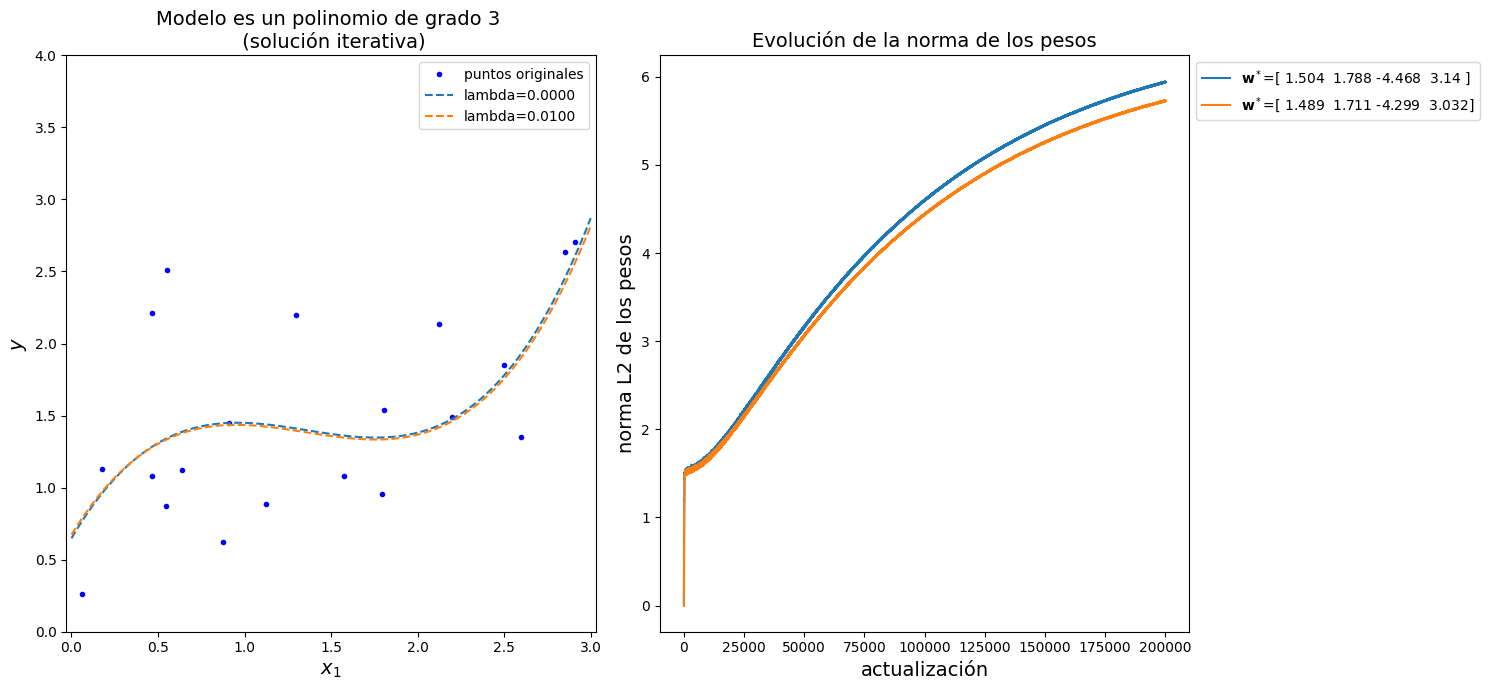

In [34]:
# Se compara solución cerrada con iterativa para un polinomio de orden no muy alto
comparar_regularizaciones(X, y, X_test, grado=3, lambdas=[0, 0.1])
comparar_regularizaciones_SGD(X,
                              y,
                              X_test,
                              lr=1e-2,
                              grado=3,
                              reg_type='Ridge',
                              lambdas=[0, 0.01],
                              estandarizar=True,
                              max_epocas=10000)

Se transformó la entrada a un polinomio grado 10, regularización Ridge
Entrenando clasificador con lambda = 0.000000


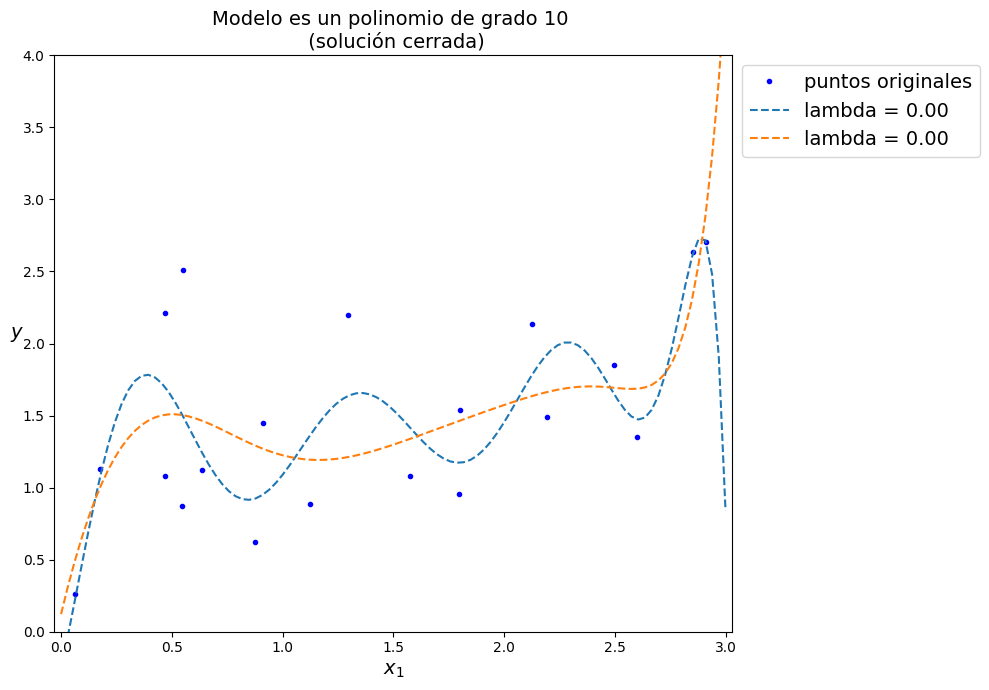

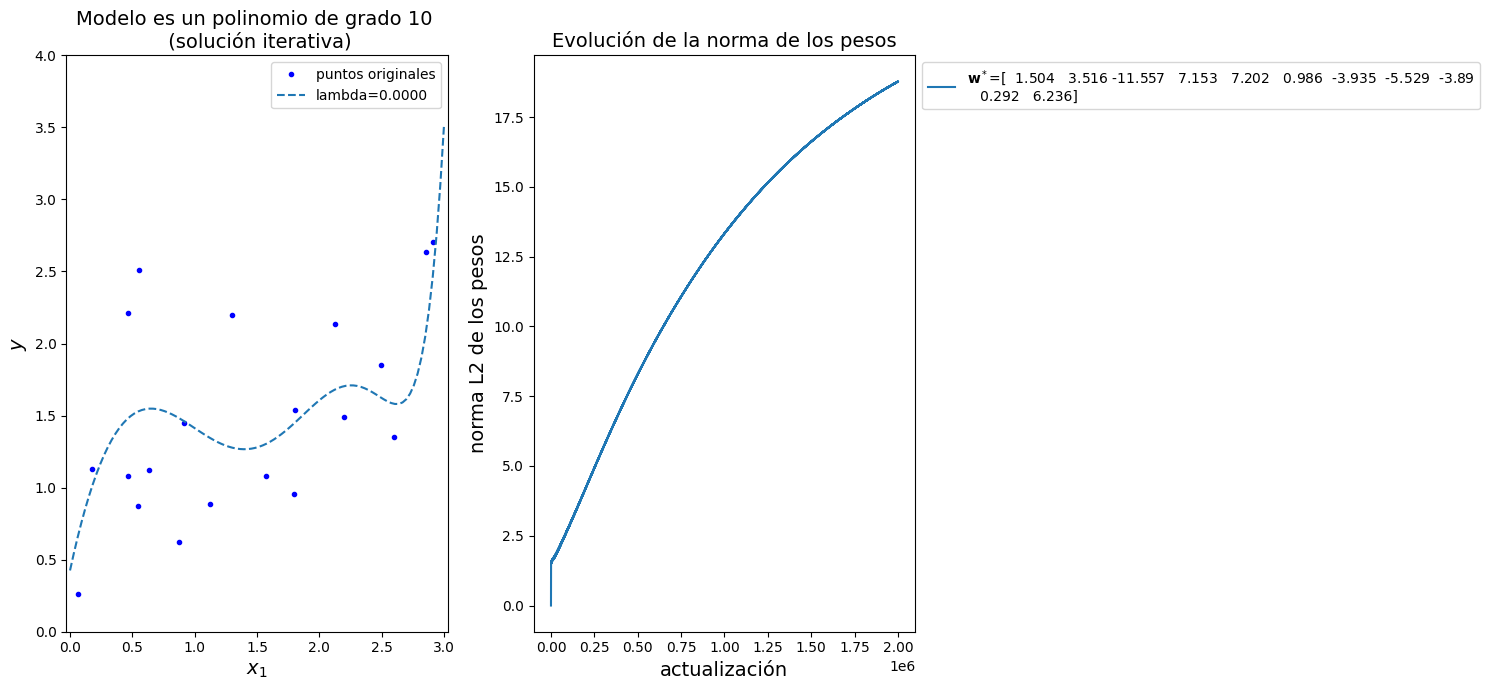

In [35]:
# Se compara solución cerrada con iterativa para un polinomio de orden alto
comparar_regularizaciones(X, y, X_test, grado=10, lambdas=[0, 1e-3])
comparar_regularizaciones_SGD(X,
                              y,
                              X_test,
                              lr=1e-2,
                              grado=10,
                              reg_type='Ridge',
                              lambdas=[0],
                              estandarizar=True,
                              max_epocas=100000)

## Comparación Lasso - Ridge

La siguiente celda compara las regularizaciones de Lasso y Ridge para el caso de un polinomio de grado alto. 

**Atención: Puede demorar varios minutos.**

Se transformó la entrada a un polinomio grado 10, regularización Ridge
Entrenando clasificador con lambda = 1.000000
Entrenando clasificador con lambda = 10.000000
Entrenando clasificador con lambda = 100.000000
Se transformó la entrada a un polinomio grado 10, regularización Lasso
Entrenando clasificador con lambda = 0.010000
Entrenando clasificador con lambda = 0.200000
Entrenando clasificador con lambda = 0.300000


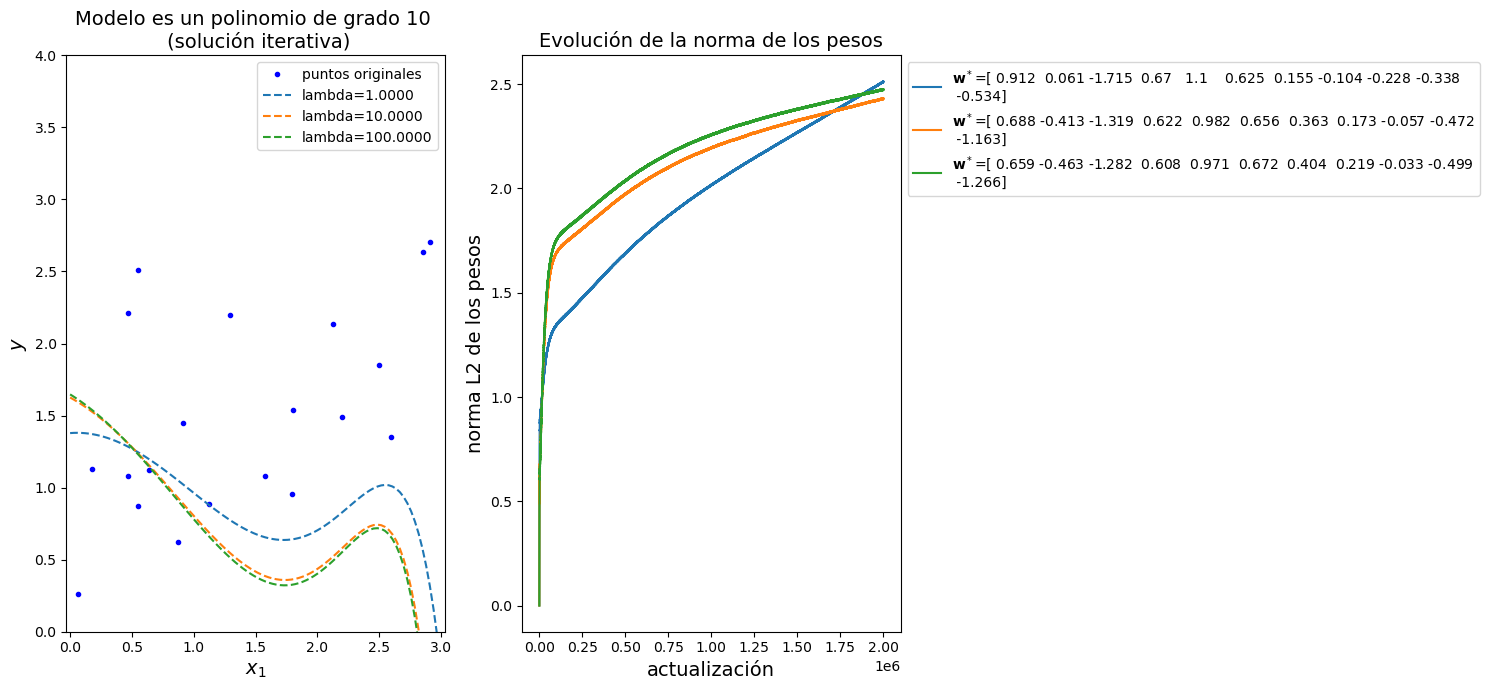

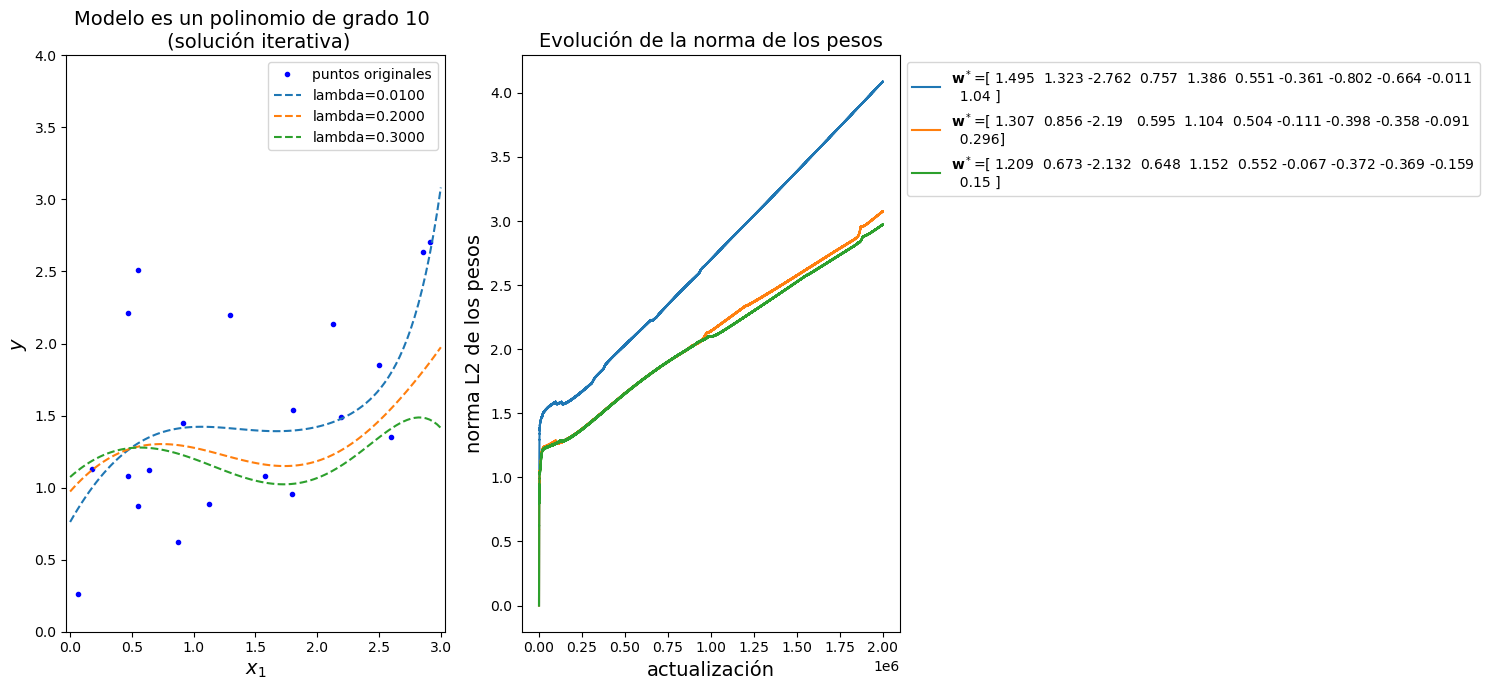

In [137]:
comparar_regularizaciones_SGD(X,
                              y,
                              X_test,
                              lr=1e-3,
                              grado=10,
                              reg_type='Ridge',
                              lambdas=[1, 10, 100],
                              estandarizar=True,
                              max_epocas=100000)

comparar_regularizaciones_SGD(X,
                              y,
                              X_test,
                              lr=1e-3,
                              grado=10,
                              reg_type='Lasso',
                              lambdas=[0.01, 0.2, 0.3],
                              estandarizar=True,
                              max_epocas=100000)

**Pregunta:** Mirando el valor que toman los vectores de pesos resultantes, ¿puede identificar alguna característica de los mismos que esté relacionada con el método de regularización utilizado?

**Respuesta:**  ...

<a id="Ejercicio4"></a>
# Ejercicio 4: Predicción del valor medio de las casas en California

En este ejercicio se trabajará con el conjunto de datos [Californa Housing](http://lib.stat.cmu.edu/datasets/houses.zip) disponible en [StatLib](http://lib.stat.cmu.edu/datasets/). Los datos fueron recabados durante el censo realizado en 1990 en California. Las características utilizadas y la descripción de las mismas se encuentran en el archivo `cadata.txt` adjunto a este notebook. Los valores de cada una de las filas corresponden a los de un grupo muestral. Estos grupos son regiones geográficamente compactas conformadas por entre 600 y 3000 personas. Por simplicidad, llamaremos a estos grupos distritos. La variable a predecir es el valor medio de las casas para cada uno de los distritos de California censados. 

In [36]:
data = np.loadtxt('./data/cadata.txt', skiprows=27)
# nombres de las características
names = [
    'median house value', 'median income', 'housing median age', 'total rooms',
    'total bedrooms', 'population', 'households', 'latitude', 'longitude'
]
X = data[:, 1:]
# la variable independiente es una transformación no lineal del median house value
y = np.log(data[:, 0] / 1000)
N = X.shape[0]  # número de muestras
Nf = X.shape[1]  # número de características
X = np.hstack([np.ones((N, 1)), X])  # Se transforma a coordenadas homogéneas

## Familiarización con los datos

La siguiente celda grafica la variable objetivo (log (median house value)/1000)) junto con cada una de las otras variables. Observar las gráficas y reflexionar sobre:
    * ¿Qué características considera de mayor utilidad ?
    * ¿Qué pre-procesamiento de los datos podría ayudar en este caso ?

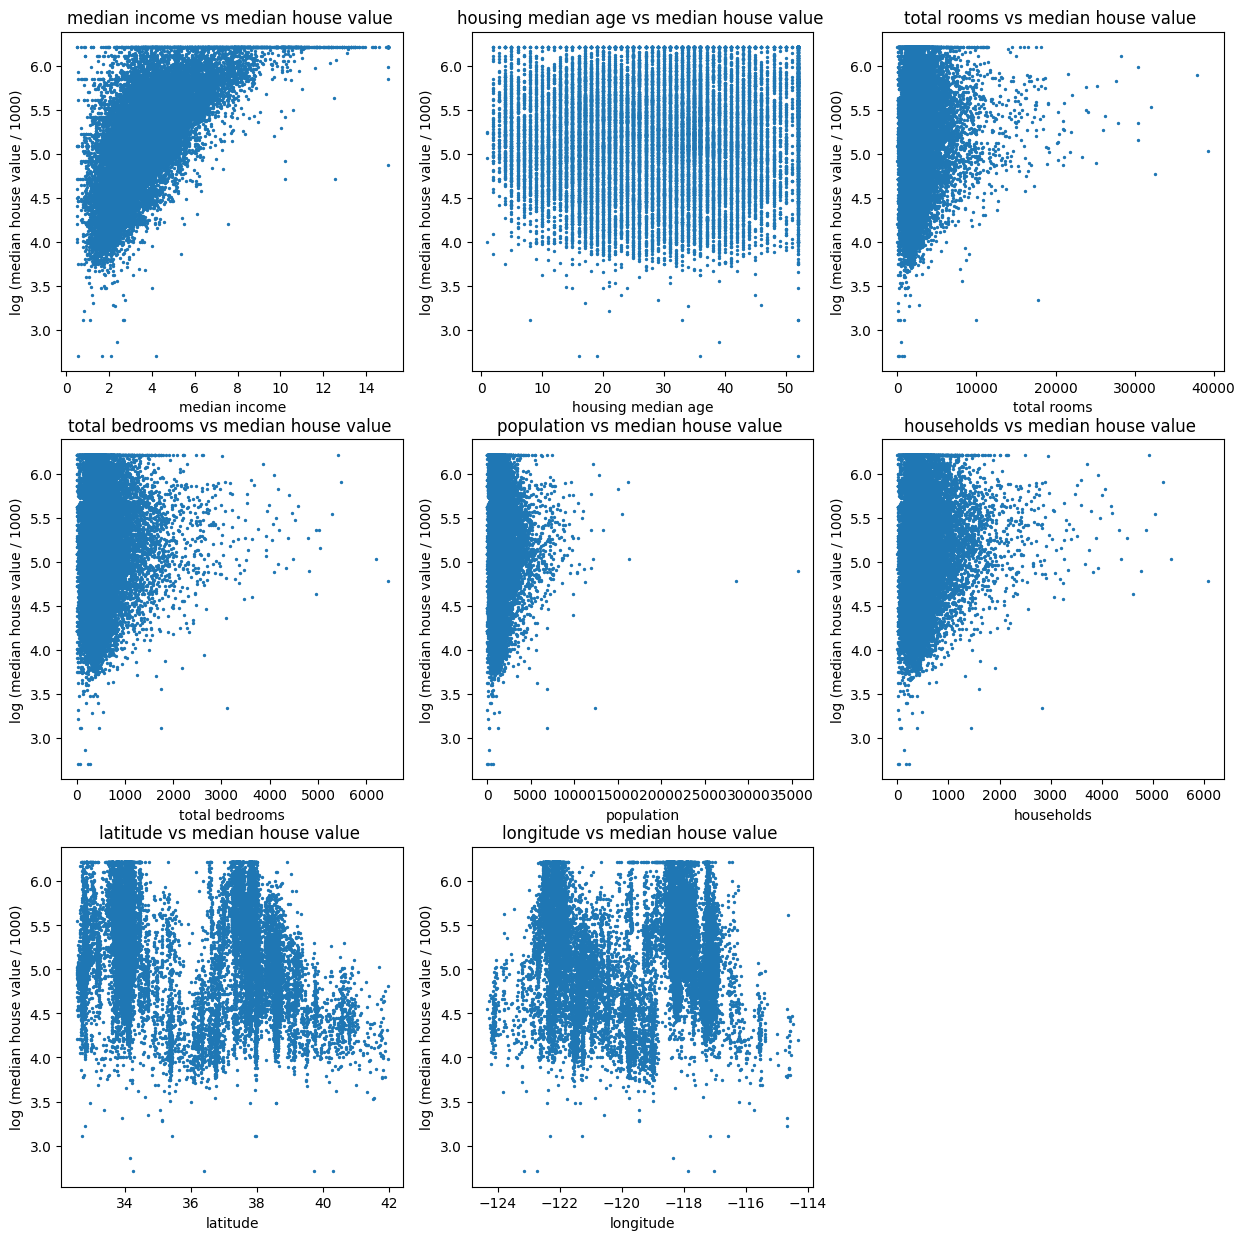

In [37]:
plt.figure(figsize=(15,15))
for n in range(Nf):
    plt.subplot(3,3,n+1)
    plt.scatter(X[:,1+n], y, s=2)
    plt.xlabel(names[1 + n])
    plt.ylabel('log (median house value / 1000)')
    plt.title('%s vs %s '% (names[1 + n],names[0] ) )

Al ser dos de los atributos la latitud y longitud de los "distritos" sensados, es posible ubicar las muestras geográficamente.

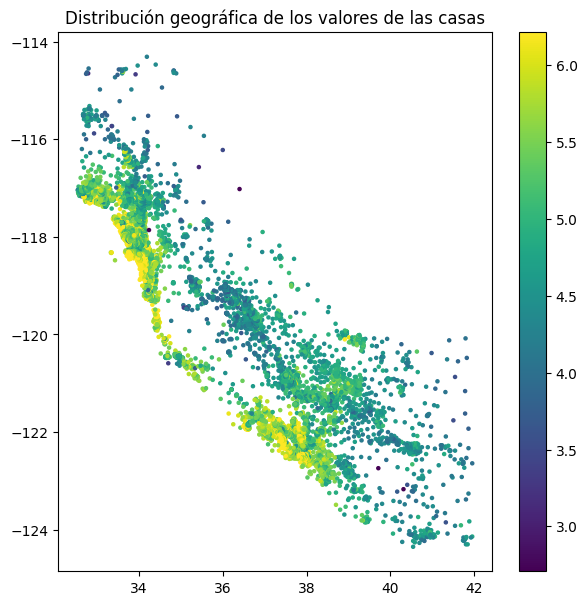

In [38]:
def mostrar_valores_casas_geograficamente(latitudes, longitudes, valores,
                                          titulo):
    plt.figure()
    plt.scatter(latitudes, longitudes, c=valores, s=5)
    plt.colorbar()
    plt.title(titulo)


mostrar_valores_casas_geograficamente(
    X[:, 7], X[:, 8], y, 'Distribución geográfica de los valores de las casas')

## Preparación de los datos

Se dividirá el conjunto de datos disponible en tres conjuntos: entrenamiento, validación y test. El conjunto de entrenamiento será utilizado para encontrar los parámetros del modelo. El conjunto de validación servirá para evaluar la capacidad de generalización del modelo encontrado con el conjunto de entrenamiento. El conjunto de test simulará ser un nuevo conjunto de datos que verá el modelo una vez que ya haya sido definido. Este conjunto deberá ser utilizado una **única** vez.    
El siguiente bloque de código divide el conjunto de datos en las siguientes proporciones:
* 60% entrenamiento
* 20% validacion
* 20% test

In [61]:
np.random.seed(42)  # 4242 da razonable
# se obtienen los puntos de corte entrenamiento/validación/test
inicioConjuntoEntrenamiento = 0
inicioConjuntoValidacion = int(0.60 * N)
inicioConjuntoTest = int(0.80 * N)

# todos los indices
#indices = np.arange(0,N)
indices = np.random.permutation(N)

# indices de conjunto de entrenamiento
indicesTrain = indices[inicioConjuntoEntrenamiento:inicioConjuntoValidacion]
# indices de conjunto de validación
indicesVal = indices[inicioConjuntoValidacion:inicioConjuntoTest]
# indices de conjunto de test
indicesTest = indices[inicioConjuntoTest:N]

# conjunto de entrenamiento
Xtrain = X[indicesTrain, :]
ytrain = y[indicesTrain]

# conjunto de validación
Xval = X[indicesVal, :]
yval = y[indicesVal]

# conjunto de test
Xtest = X[indicesTest, :]
ytest = y[indicesTest]

La siguiente celda muestra la distribución geográfica de los distritos utilizados para entrenamiento/validación/test

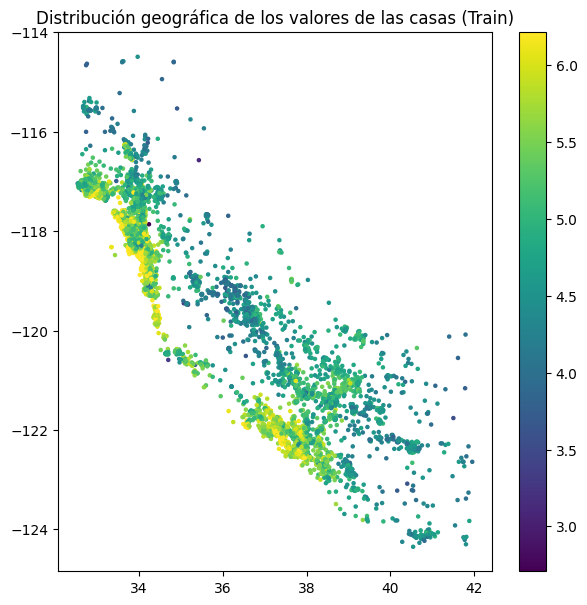

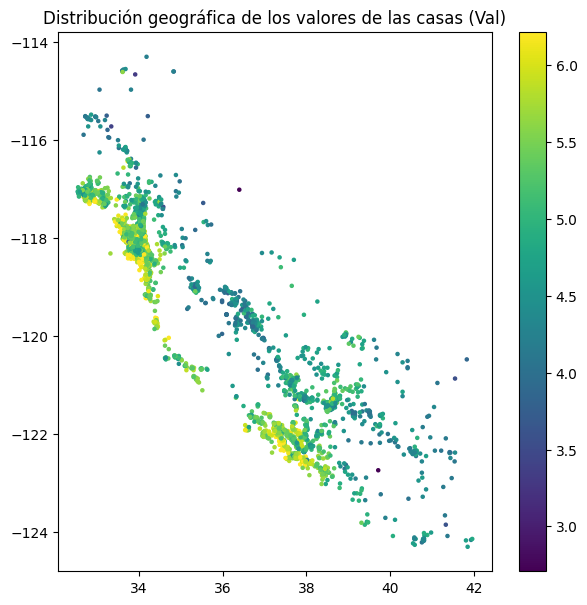

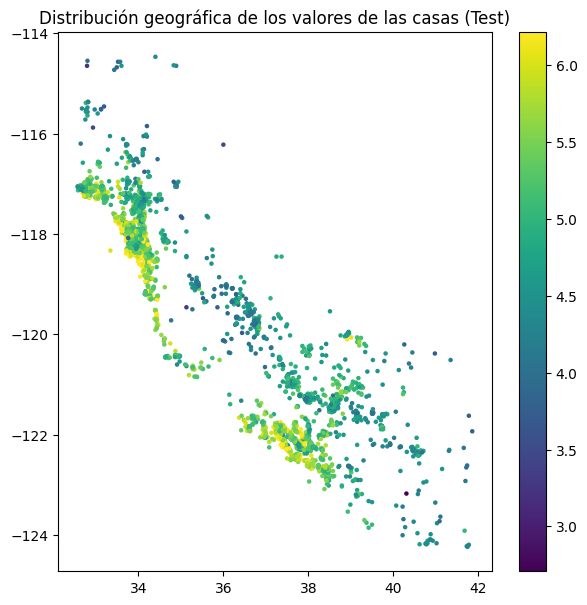

In [62]:
mostrar_valores_casas_geograficamente(
    Xtrain[:, 7], Xtrain[:, 8], ytrain,
    'Distribución geográfica de los valores de las casas (Train)')
mostrar_valores_casas_geograficamente(
    Xval[:, 7], Xval[:, 8], yval,
    'Distribución geográfica de los valores de las casas (Val)')
mostrar_valores_casas_geograficamente(
    Xtest[:, 7], Xtest[:, 8], ytest,
    'Distribución geográfica de los valores de las casas (Test)')

## Pregunta 1

La separación de los conjuntos realizada anteriormente no parece adecuada. Explicar por qué. 

**Respuesta:**  ...  

## Pregunta 2

Cambiar una línea del bloque que genera los conjuntos de entrenamiento/validación/test de forma que la separación sea más razonable.

**Respuesta:**  ...  

## Pregunta 3

Ajustar el modelo de regresión lineal a los datos de entrenamiento.

In [41]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

w_ls_houses = regresion_lineal(Xtrain,ytrain)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

Evaluar el funcionamiento con el conjunto de validación utilizando el método `mostrar_ajuste()`. Para ello se debe implementar primero el método `predecir()` que devuelve el valor estimado por el modelo. 

In [42]:
def predecir(X, w):
    '''
    Devuelve la predicción realizada por el modelo lineal. En este caso se decide además poner a cero
    aquellas estimaciones que sean negativas por considerarlas equivocadas.
    Entrada:
        X: matriz de dimensión (N,d+1) que contiene las características a utilizar
        w: vector de pesos de dimensión (d+1,)
    Salida:
        y: Vector de tamaño N que contiene las predicciones realizadas por el modelo. 
           Cuando la predicción es un valor negativo se devuelve cero en dicha componente del vector y.
    '''

    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################
    
    y = np.dot(X,w)

    for i in range(0,len(y)):
        if np.sign(y[i]) < 0:
            y[i] = 0
          

    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    return y

In [43]:
def mostrar_ajuste(y, y_pred):
    '''
    Entrada:
        y: vector que contiene los valores objetivo
        y_pred: vector que contiene los valores estimados
    '''
    plt.figure()
    plt.scatter(y, y_pred, s=2, label='predicciones')
    plt.xlabel("Valores reales", fontsize=18)
    plt.ylabel("Valores estimados", fontsize=18)
    plt.plot(np.linspace(y.min(), y.max()),
             np.linspace(y.min(), y.max()),
             c='r',
             label='estimaciones ideales')
    plt.title("Valores reales vs estimaciones", fontsize=18)
    plt.legend()
    plt.tight_layout()

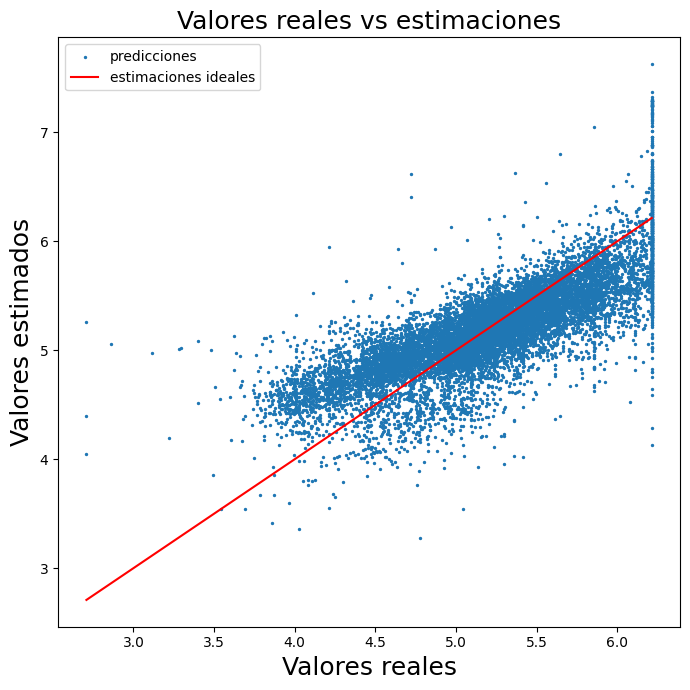

In [44]:
mostrar_ajuste(ytrain, predecir(Xtrain, w_ls_houses))

## Pregunta 4

¿Qué características contribuyen más a explicar el precio promedio de las casas? ¿Coincide con su intuición?

<BarContainer object of 8 artists>

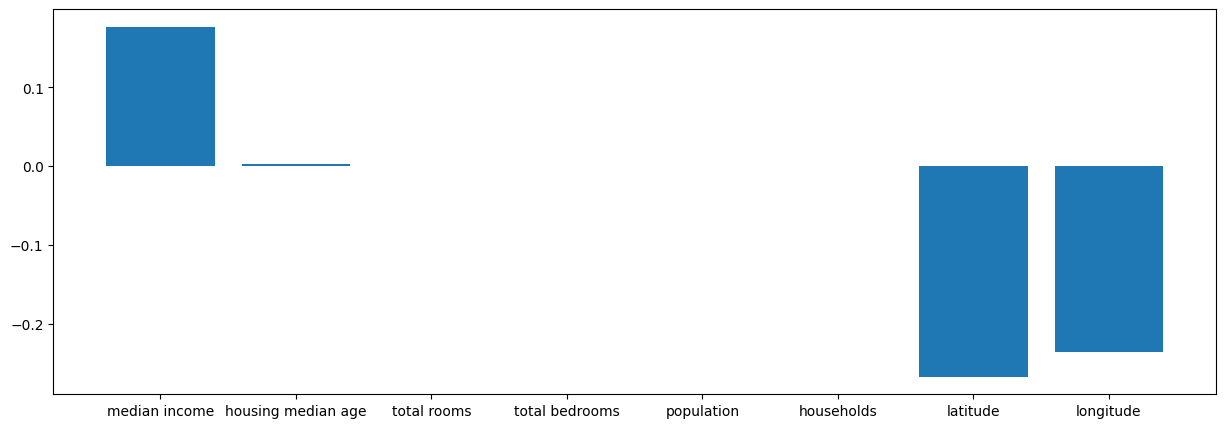

In [45]:
plt.figure(figsize=(15, 5))
plt.bar(range(8), w_ls_houses[1:], tick_label=names[1:])

**Respuesta:**  ...  

## Pregunta 5

Una buena práctica habitual es trabajar con características que estén en el mismo rango de valores. En este ejercicio se utilizará la técnica de escalado conocida como *estandarización*.  Utilizar el método `estandarizar_caracteristicas()` implementado en el ejercicio 3 para estandarizar los datos de entrenamiento. Luego utilizar las medias y desviaciones estándar calculadas para estandarizar los conjuntos de validación y test.

In [46]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

# Características de entrenamiento estandarizadas (expresadas en coordenadas homogéneas)
Xtrain_std , mu =estandarizar_caracteristicas(Xtrain,None)

# Características de validación estandarizadas (expresadas en coordenadas homogéneas)
Xval_std, _ = estandarizar_caracteristicas(Xval,mu)

# Características de test estandarizadas (expresadas en coordenadas homogéneas)
Xtest_std, _ = estandarizar_caracteristicas(Xtest,mu)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

**Pregunta:** En vez de utilizar las estadísticas del conjunto de entrenamiento para estandarizar los conjuntos de validación y test, ¿podría haberse realizado la estandarización de los conjuntos de entrenamiento, validación y test por separado? ¿o una sola estandarización utilizando las muestras de todos los conjuntos? 

**Respuesta:**  No, porque queremos usar la estandarizacion solo del conjunto de train, porque sino estariamos usando los otros conjuntos que no tienen la misma media y desv estandar. Ademas me da la sensacion que esos conjuntos no se pueden utilizar salvo para la validacion o el test final, lo cual afectaria al resultado

La siguiente celda muestra la distribución de las características estandarizadas.

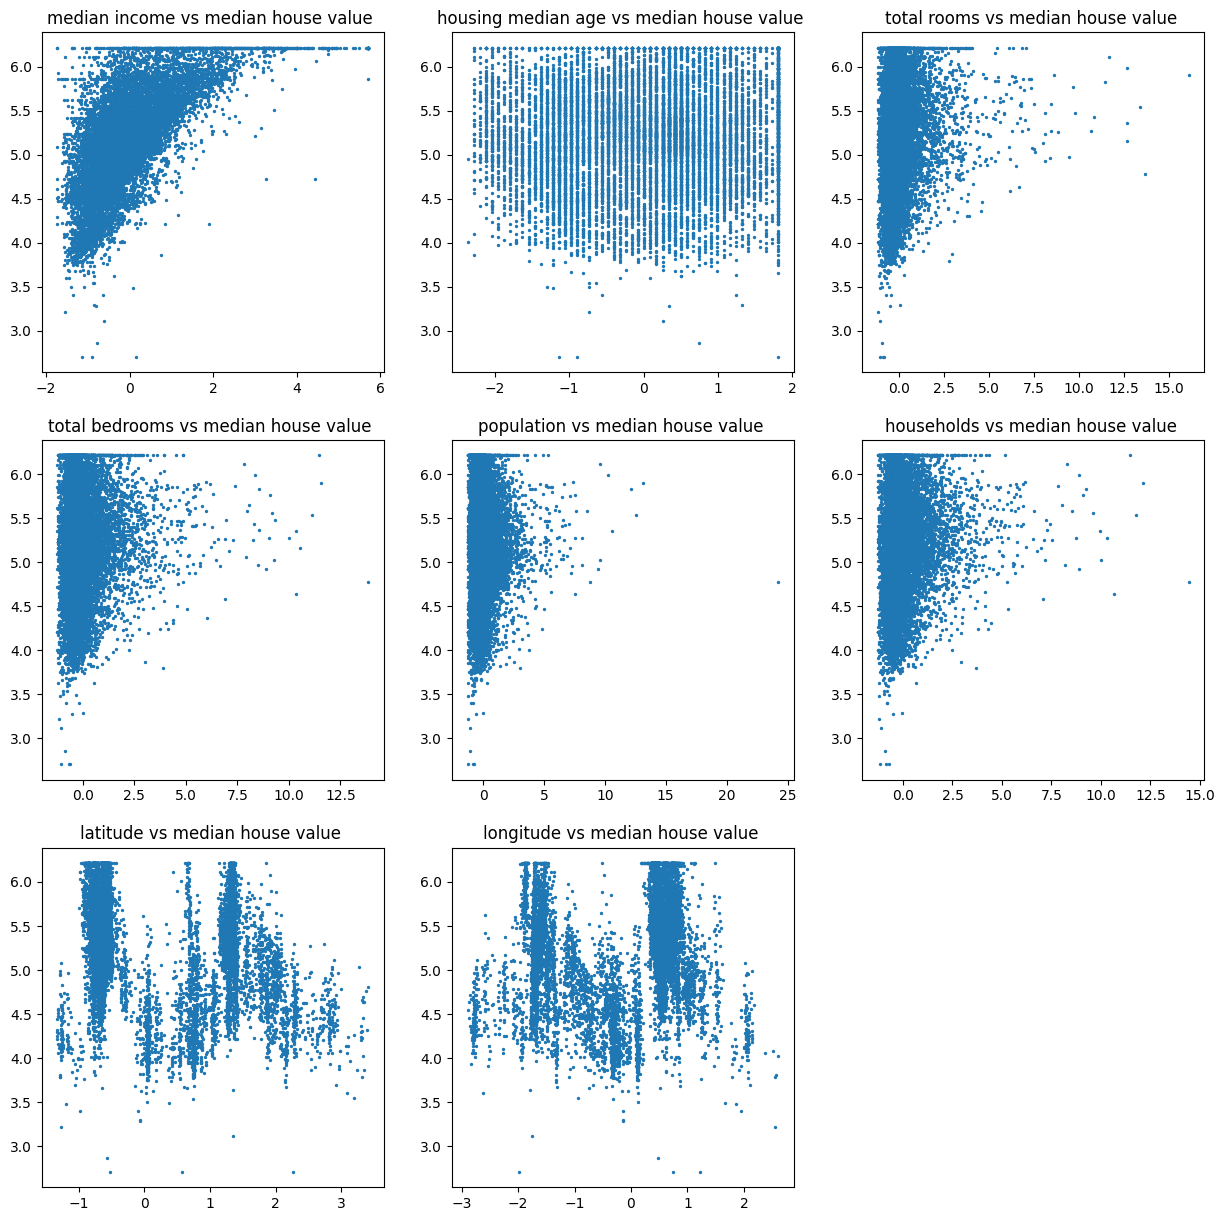

In [47]:
plt.figure(figsize=(15, 15))
for n in range(Nf):
    plt.subplot(3, 3, n + 1)
    plt.scatter(Xtrain_std[:, 1 + n], ytrain, s=2)
    plt.title('%s vs %s ' % (names[1 + n], names[0]))

## Pregunta 6

Ajustar el modelo de regresión lineal a los datos de entrenamiento con las características estandarizadas. Comente cómo cambia el modelo y la interpretación de los pesos. 

**Respuesta:**  ... 

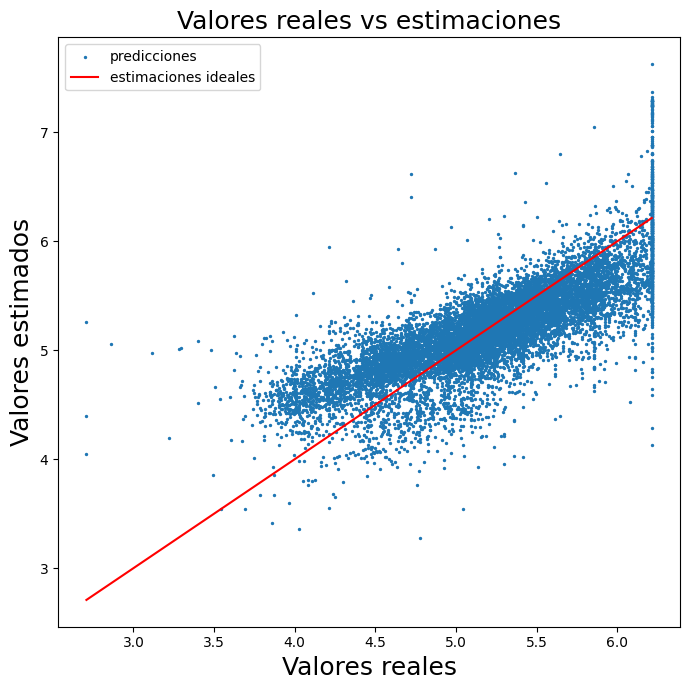

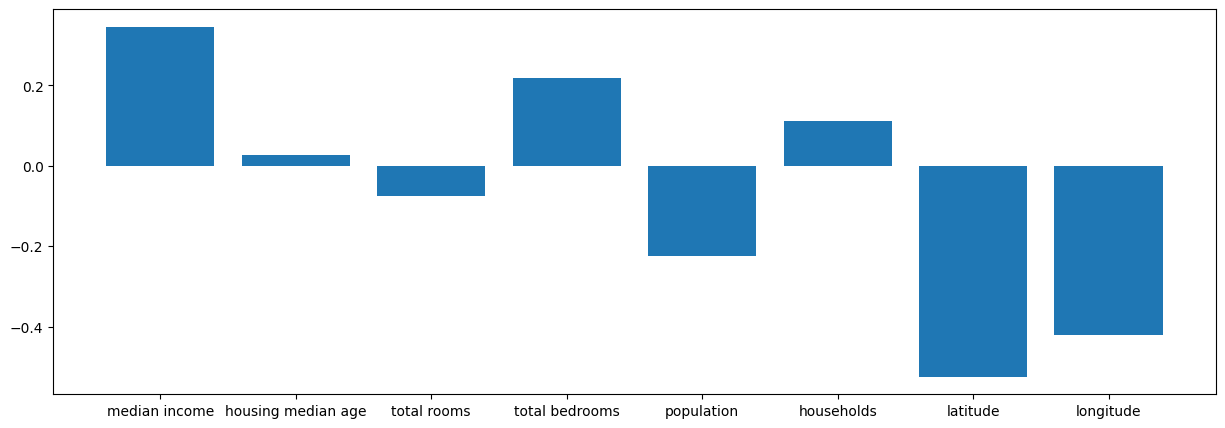

In [48]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

w_ls_houses_std = regresion_lineal(Xtrain_std,ytrain)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

mostrar_ajuste(ytrain, predecir(Xtrain_std, w_ls_houses_std))
plt.figure(figsize=(15, 5))
plt.bar(range(8), w_ls_houses_std[1:], tick_label=names[1:]);

## Pregunta 7

Implemente la función `rmse()` y utilícela para estimar el error cometido en la predicción. 

In [49]:
def rmse(y, y_pred):
    '''
    Método que implementa el rmse (root mean square error) 
    entre los valores objetivos y los valores estimados.
    Entrada:
        y: vector con los valores objetivos
        y_pred: vector con los valores estimados
    '''
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    rmse = np.sqrt(np.mean((y-y_pred)**2))
    
    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
    #####################################################

    return rmse

In [50]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

# Se calcula el error de entrenamiento y validación  utilizando características sin estandarizar
rmse_train = rmse( predecir(Xtrain, w_ls_houses) ,ytrain)

rmse_val = rmse ( predecir(Xval,w_ls_houses) ,yval)



# Se calcula el error de entrenamiento y validación  utilizando características estandarizadas
rmse_train_std = rmse( ytrain , predecir(Xtrain_std, w_ls_houses_std) )

rmse_val_std = rmse( yval , predecir( Xval_std , w_ls_houses_std ) )

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

## Pregunta 8

¿Cuál es el error *rmse* cometido en las estimaciones expresado en dólares?  

In [51]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################


print(1000*np.exp(rmse_train))
print(1000*np.exp(rmse_train_std))
print(1000*np.exp(rmse_val))
print(1000*np.exp(rmse_val_std))


#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

1412.846643733299
1412.846643733299
1434.7695737152071
1434.7695737120316


**Nota:** El error en dinero se calcula como: 1000 * np.exp(rmse)

##  Pregunta 9

La función `transformacion_polinomica_para_predecir_valores_casas()` realiza una transformación polinómica a un espacio de mayor dimensión.  Utilizarla con $n=3$ para transformar las características a un espacio de mayor dimensión y encontrar los parámetros de un modelo lineal en dicho espacio. Calcular el error de entrenamiento y validación en términos de *rmse* cuando se utilizan características polinomiales. 

In [52]:
def transformacion_polinomica_para_predecir_valores_casas(X, n=2):
    '''
    Se realiza una transformación de los datos de entrada utilizando
    para cada característica monomios de hasta grado  n
    Ej con n=3 : [1, x1, x2] --> [1, x1, x2, x1^2, x2^2, x1^3, x2^3]
    Entrada:
            X: matriz de tamaño (N,d+1) que en cada fila contiene un vector
               de características expresado en coordenadas homogéneas
        grado: grado de la transformación polinómica
    '''
    
    N = X.shape[0]
    d = X.shape[1] - 1
    X_poly = np.ones((N, 1 + n * d))
    for g in range(n):
        for f in range(d):
            X_poly[:, 1 + d * g + f] = X[:, 1 + f]**(g + 1)
    return X_poly

(12384, 9)
w =[ 2.42e+02  2.77e-01  1.47e-02 -1.66e-04  2.14e-03 -4.31e-04  1.02e-04
 -3.80e+01 -1.03e+00 -3.12e-03 -5.45e-04  1.01e-08 -7.50e-07  4.79e-08
  6.73e-09  9.79e-01  3.32e-02 -4.67e-04  7.02e-06 -2.12e-13  9.08e-11
 -1.24e-12 -1.71e-11 -8.43e-03  2.02e-04]
El error de entrenamiento es 0.2997 y de validación es 0.4991


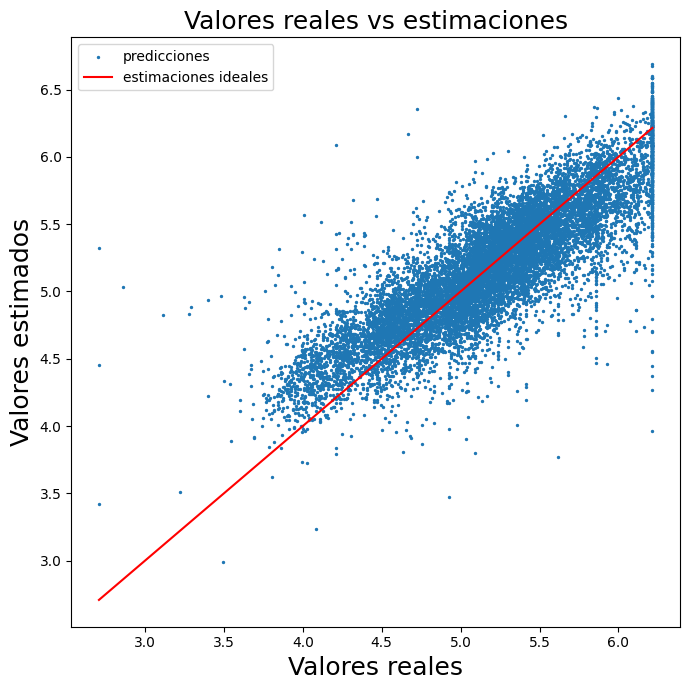

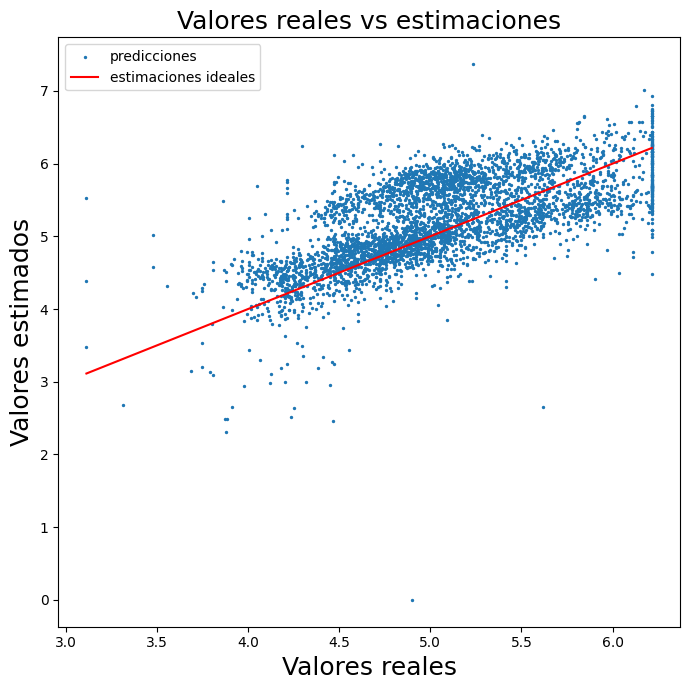

In [53]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

Xtrain_poly3 = transformacion_polinomica_para_predecir_valores_casas(Xtrain,3)

Xval_poly3 = transformacion_polinomica_para_predecir_valores_casas(Xval,3)

w_ls_houses_poly = regresion_lineal(Xtrain_poly3,ytrain)

ytrain_pred_poly = predecir(Xtrain_poly3,w_ls_houses_poly)

yval_pred_poly =  predecir(Xval_poly3,w_ls_houses_poly)

rmse_train_poly = rmse(ytrain,ytrain_pred_poly)

rmse_val_poly = rmse ( yval, yval_pred_poly)

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################
print(Xtrain.shape)
mostrar_ajuste(ytrain, ytrain_pred_poly)
mostrar_ajuste(yval, yval_pred_poly)

# print('w= ', w_ls_houses_poly)
print('w =%s' % (np.array2string(w_ls_houses_poly, precision=2)))
print('El error de entrenamiento es %.4f y de validación es %.4f' %
      (rmse_train_poly, rmse_val_poly))

## Pregunta 10

¿Considera que vale la pena aplicar regularización. En caso afirmativo implemente algunas de las formas vistas en el práctico y encuentre un factor de regularización adecuado. En caso contrario, justifique su decisión.

**Respuesta**  ... no

## Pregunta 11

En función de los resultados obtenidos elija uno de los modelos considerados y evalúelo con el conjunto de test. 

#### Conjunto de test

In [55]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################
wridge = regresion_Ridge(Xtrain,ytrain,0.1)

#Regresión lineal
ytest_pred = predecir(Xtest,wridge)
#ytest_pred = predecir(Xtest,w_ls_houses)
rmse_test = rmse(ytest,ytest_pred)
print(rmse_test)

# Regresión lineal con datos estandarizados
# ytest_pred =
# rmse_test =

# Regresión lineal con ajuste polinomial
# ytest_pred =
# rmse_test =

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CÓDIGO #######
#####################################################

0.3277347946480311
